# Байесовская статистика
## Задание BS.5


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---

**Баллы за задание:**

* Задача 1 &mdash; 40 баллов
* Задача 2 &mdash; 60 баллов
* Задача 3 &mdash; 20 баллов
* Задача 4 &mdash; 70 баллов
* Задача 5 &mdash; 60 баллов
---

In [1]:
# Bot check

# HW_ID: ds_bs5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from sklearn.datasets import make_blobs
import time
from statsmodels.tsa.stattools import acf

sns.set(font_scale=1.2, style='whitegrid', palette='Set2')

___
### Задача 1

Реализуйте функцию, для генерации выборки из экспоненциального распределения с параметром 1 с помощью гамильтонова MCMC.

Формулы с занятия

$$K(v) = \frac{v^2}{2} \qquad U(x) = - \log p(x) = - \log \left( 1 \cdot e^{-1 \cdot x} \right) = x \Rightarrow H(x, v) = x + \frac{v^2}{2}$$

$$ v' = - \partial_x U = -1 \qquad x' = v \qquad \Rightarrow \qquad v = -t + C \qquad x = -\frac{t^2}{2} + t C + B$$

$$v(t) = \hat v - t \qquad x(t) = - \frac{t^2}{2} + t \hat v + x_{prev}$$

где $\hat v \sim N(0, 1)$, $x_{prev}$ - время предыдущее значение координаты, новая координата есть $x(T)$, где $T$ - время запуски динамики

In [50]:
def hamilton_sample(x_0, t, size=2000, tune=500):
    '''
    :param x_0: стартовая координата
    :param t: время, на которое запускается динамика
    :param size: конечный размер выборки
    :param tune: количество семплирований для настройки цепи
    '''
    result = [0] * (tune + size + 1)
    result[0] = x_0
    p_start  = np.random.normal(size=tune + size + 1)
    
    for i in range(1, tune + size + 1):
        result[i] = abs(- t ** 2 / 2 + t * p_start[i] + result[i-1])
        
    return np.array(result[-size:])

Исследуйте, как на полученную выборку влияет начальное приближение и время динамики $t$. Сравнение производите по гистограммам.

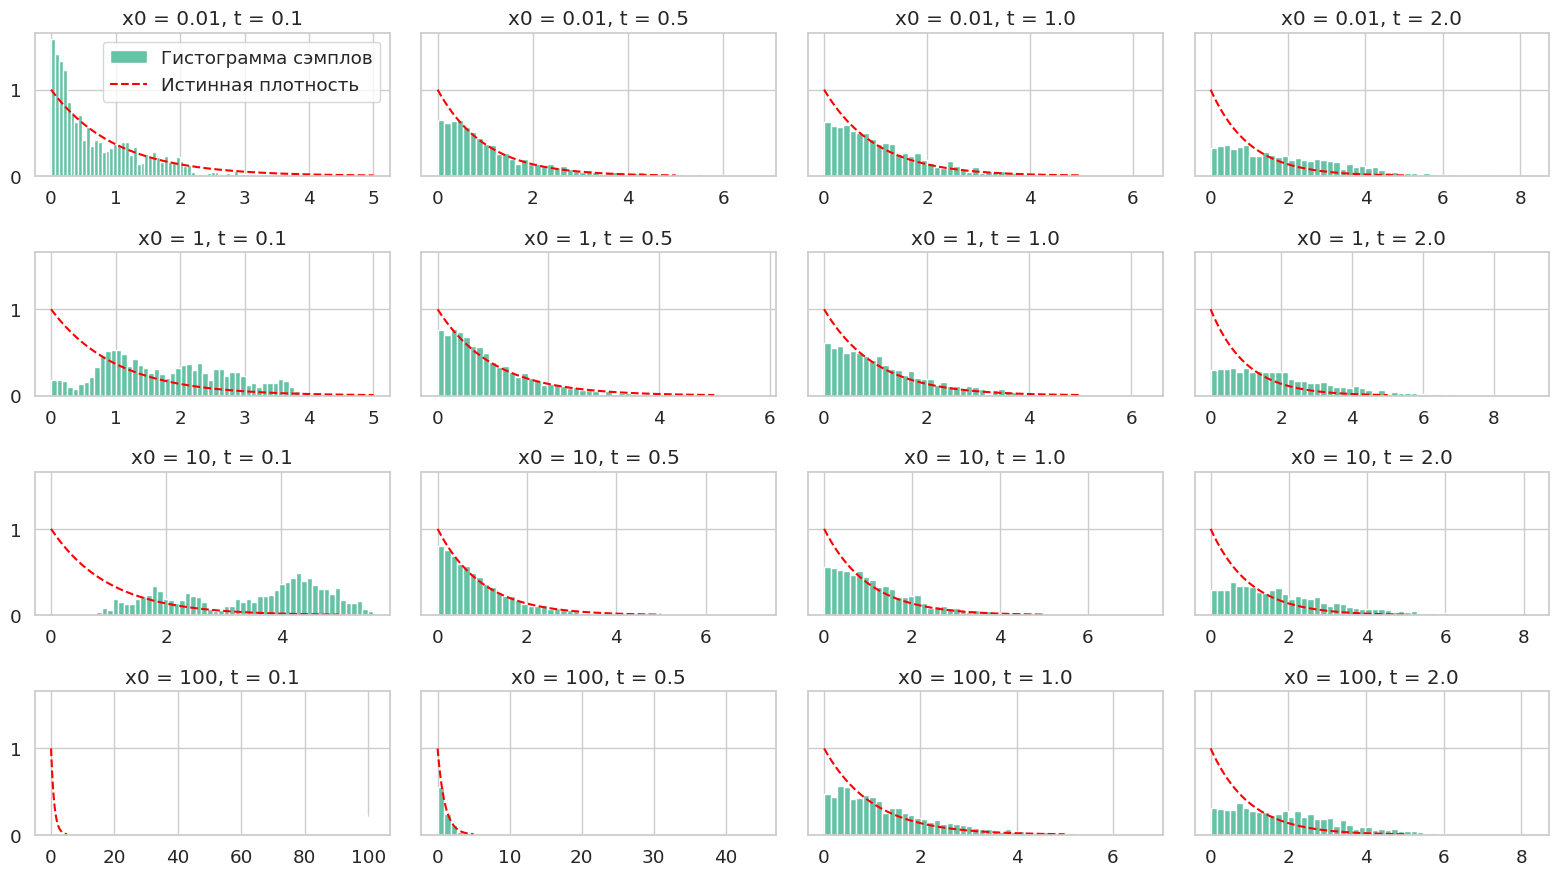

In [33]:
x0_values = [0.01, 1, 10, 100]
t_values = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(len(x0_values), len(t_values), figsize=(16, 9), sharey=True)

for i, x0 in enumerate(x0_values):
    for j, t in enumerate(t_values):
        samples = hamilton_sample(x0, t)
        axes[i, j].hist(samples, bins=50, density=True, label="Гистограмма сэмплов")
        dots = np.linspace(0, 5, 200)
        axes[i, j].plot(dots, sps.expon.pdf(dots, scale=1), 'r--', label="Истинная плотность")
        axes[i, j].set_title(f"x0 = {x0}, t = {t}")
        if i == 0 and j == 0:
             axes[i, j].legend()

plt.tight_layout()
plt.show()

Слишком большое время - искажение выборки, за счет увеличения среднего - динамика происходит на больших координатах

Слишком маленькое время - похоже на скоррелированность данных, есть скачки плотностей

Слишком большая начальная координата - динамика может не попасть в истинную вероятную область значений (при досмтаточно маленьком t), плюс искажения из за больших значений

Маленькие начальные координаты особо не ломают за счет того, что там максимум плотности

При этом часто происходит много отскоков от x=0

Выберите оптимальные параметры и сравните результат с методами Rejection sampling и схемой Метрополиса-Хастингса. Сравнение произведите по следующим характеристикам:
* гистограмма по сгенерированной выборке в сравнении с истинной плотностью;
* математическое ожидание и дисперсия по сгенерированной выборке в сравнении с истинными значениями;
* автокорреляционная функция по сгенерированной "выборке";
* время работы.

Для сравнения не используйте те данные, по которым цепь производила настройку.

В качестве параметров для гамильтонова МСМС возьмем $x_0 = 1, t = 0.5$

Получить верхнюю оценку оценку на плотность распределения очень просто

$$p(x) \leq p(1) = e^{-1}$$

Для Rejection sampling будем мажорировать равномерным распределением на отрезке $[0, 10]$ (соотвественно с плотностью $q(x) = \frac{1}{10}$)

Итого имеем с более завышенной оценкой для хвоста $$p(x) \leq 10 \cdot e^{-1} \cdot 1.3 \cdot q(x)$$

Реализуем Rejection sampling:

In [51]:
def rejection_sample(size=2000):
    '''
    :param size: конечный размер выборки
    '''
    sample = []
    const = 10 * np.exp(-1) * 1.3
    
    while len(sample) < size:
        x = np.random.uniform(0, 10)
        u = np.random.rand()
        if u < np.exp(-x) / const:
            sample.append(x)
    
    return np.array(sample)

Осталось реализовать процедуру Метрополиса-Хастинга. Будем генерить новое состояние так:
$$q(x' | x) \sim N(x, \sigma^2)$$
$$q(x | x') \sim N(x', \sigma^2)$$

тогда они сократятся в подсчете $\alpha$ (в плотности будет квадрат разности $x'$ и $x$)

In [52]:
def metropolis_hastings(x0=0.1, size=2000, sigma=0.5,
                         tune=500, step=10):
    '''
    :param x_0: стартовая координата
    :param size: конечный размер выборки
    :param sigma: дисперсия при подсчете нового состояния
    :param step: число шагов для выбора новой точки выборки
    :param tune: количество семплирований для настройки цепи
    '''
    sample = []
    prev = x0

    while len(sample) < tune + size * step:
        cur = prev + np.random.normal(scale=sigma)

        if cur < 0:
            sample.append(prev)
            continue
        
        alpha = min(1.0, np.exp(-cur) / np.exp(-prev))
        if np.random.rand() < alpha:
            prev = cur
        sample.append(cur)

    return np.array(sample[tune::10])

Запустим сравнение гистограмм. На первый взгляд, rejection дает более плавное приближение, а так все методы справились примерно хорошо

<Figure size 1500x600 with 0 Axes>

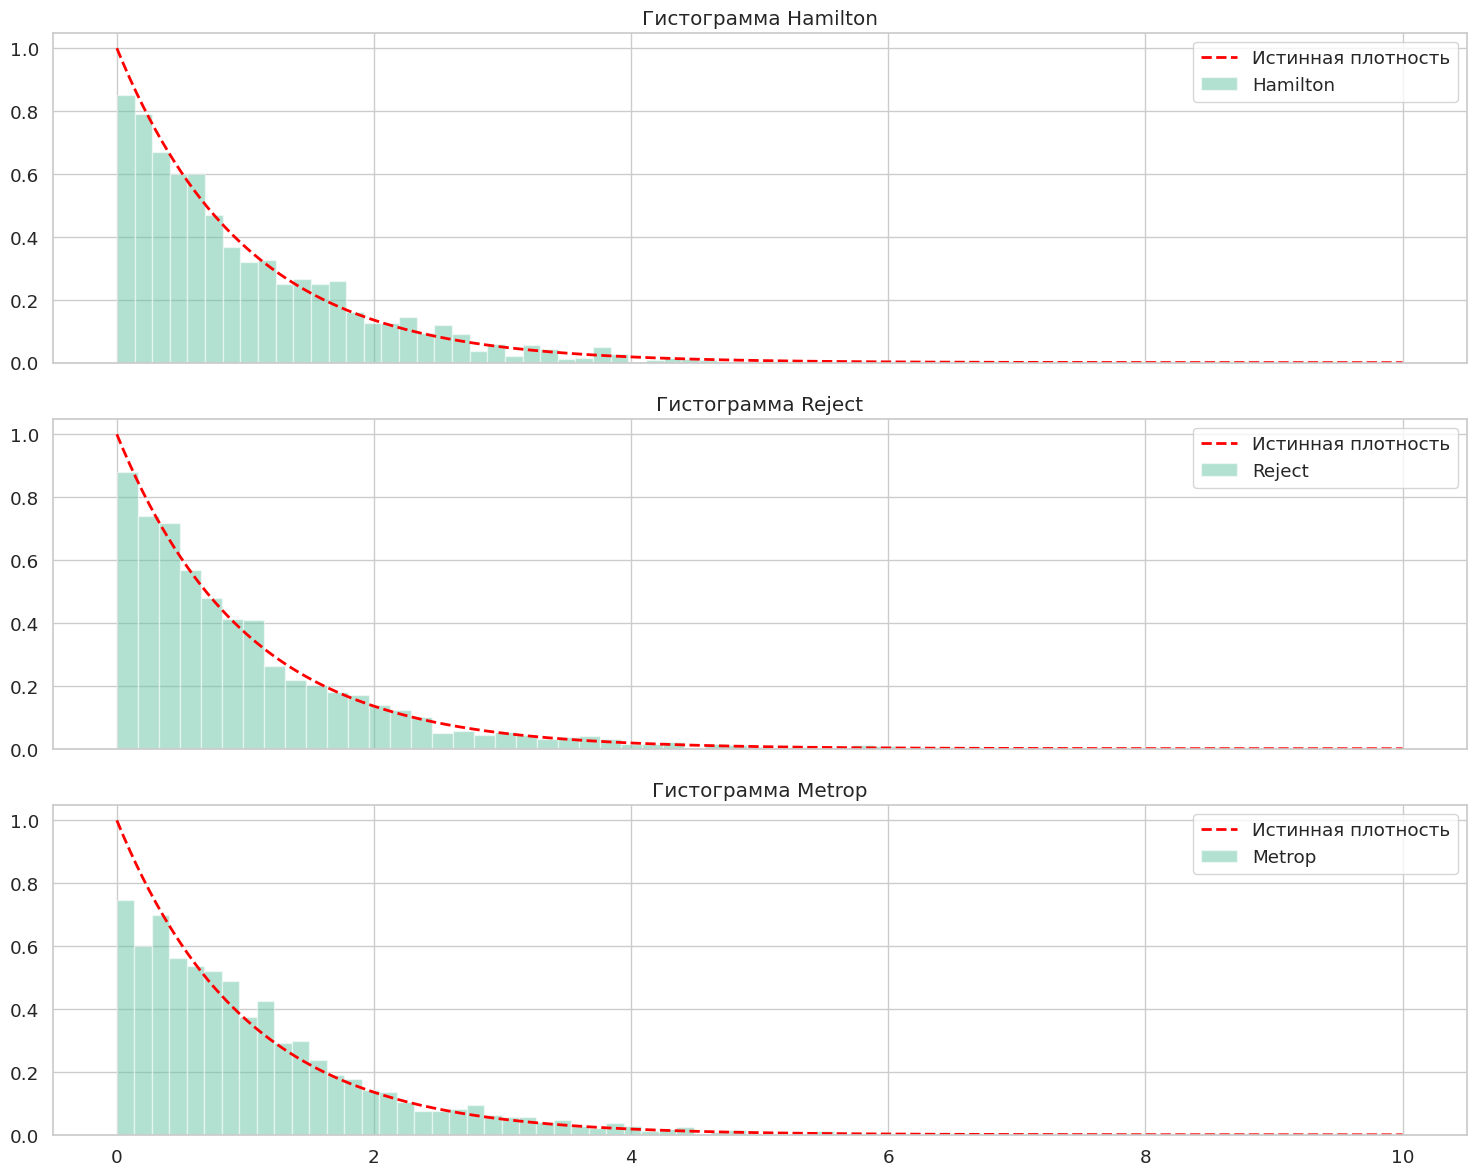

In [62]:
hamilton = hamilton_sample(x_0=1, t=0.5)
rej = rejection_sample()
mh = metropolis_hastings()

plt.figure(figsize=(15, 6))

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
x = np.linspace(0, 10, 200)
for ax, data, label in zip(axs, [hamilton, rej, mh], ["Hamilton", "Reject", "Metrop"]):
    ax.plot(x, np.exp(-x), 'r--', label="Истинная плотность", linewidth=2)
    ax.hist(data, bins=50, density=True, alpha=0.5, label=label)
    ax.legend()
    ax.set_title(f"Гистограмма {label}")
plt.tight_layout()
plt.show()

Сравним автокорреляционные функции

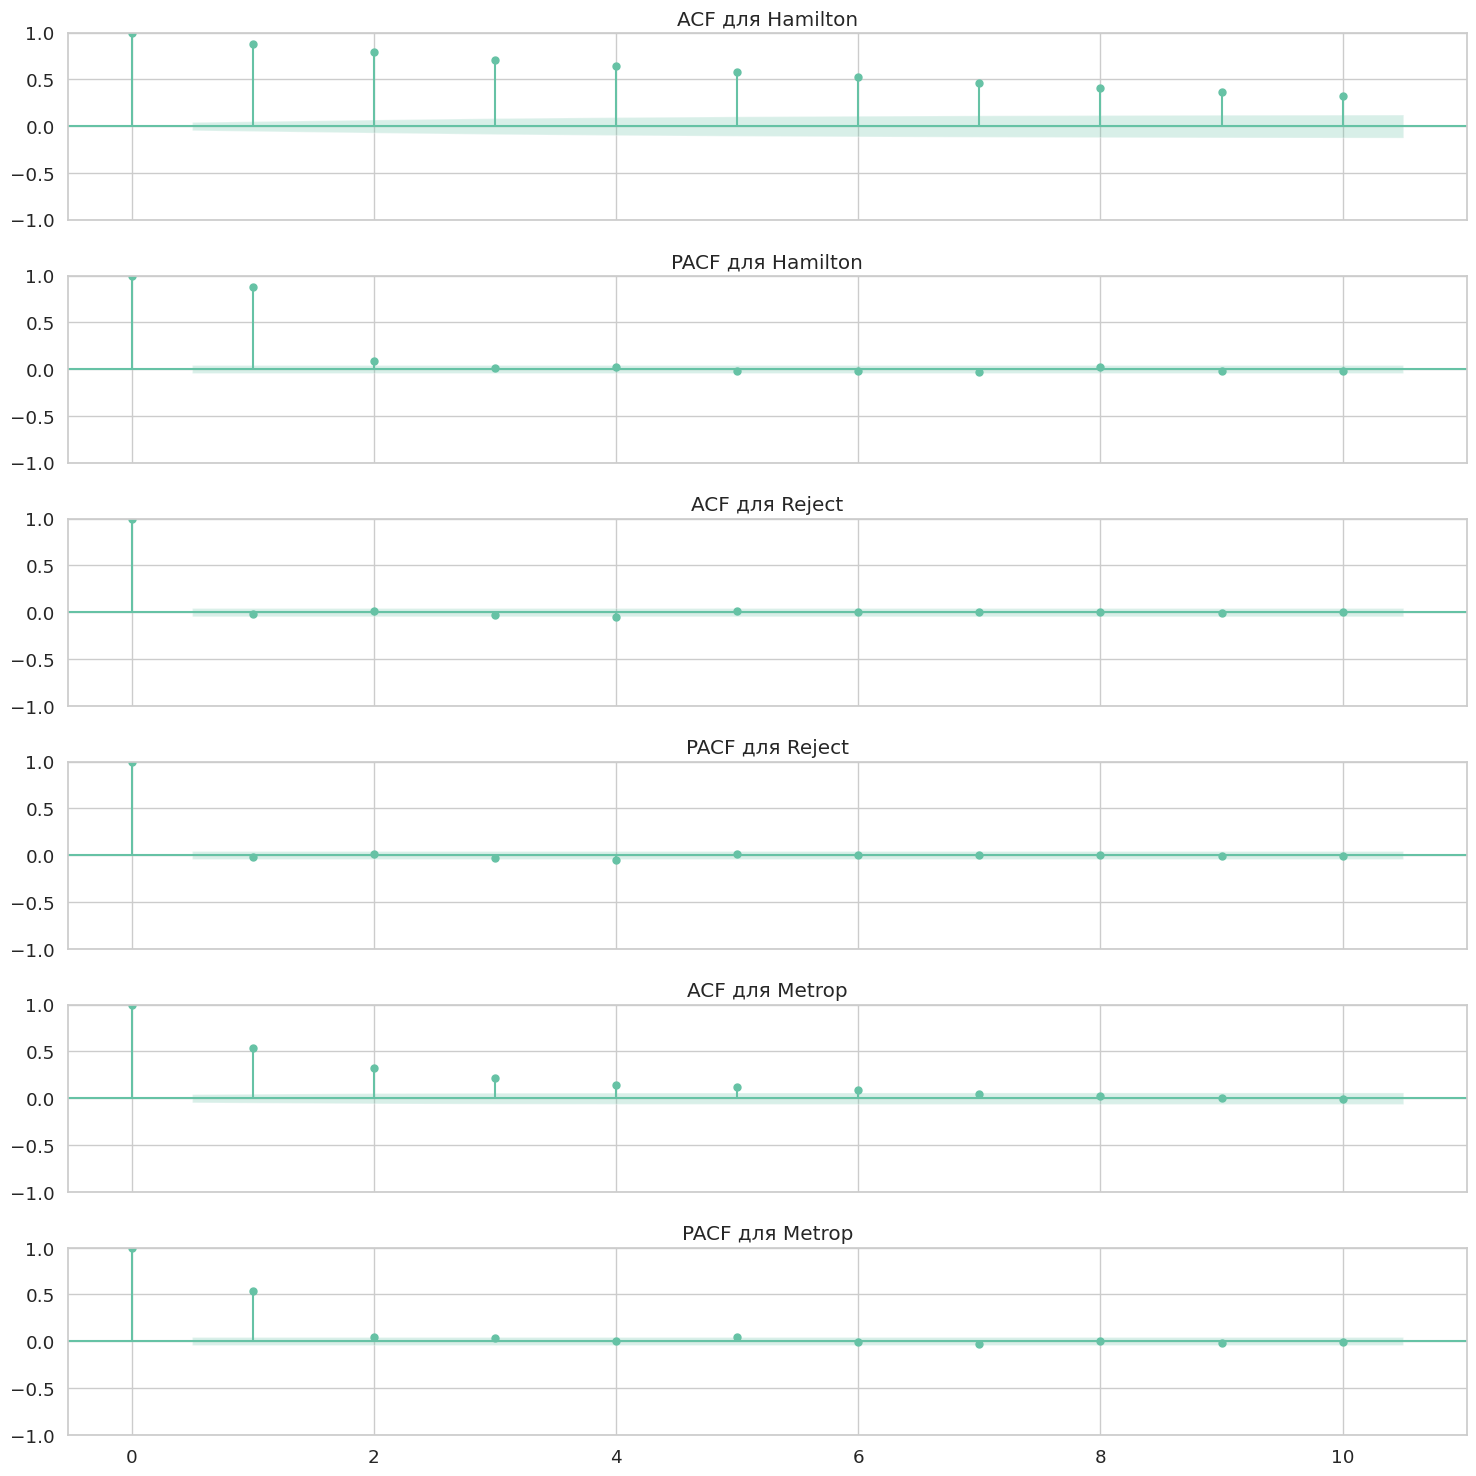

In [73]:
import statsmodels.api as sm
from tqdm import tqdm

fig, axs = plt.subplots(6, 1, figsize=(15, 15), sharex=True)
x = np.linspace(0, 10, 200)
for i, (data, label) in enumerate(zip([hamilton, rej, mh], ["Hamilton", "Reject", "Metrop"])):
    sm.graphics.tsa.plot_acf(data, lags=10, ax=axs[2 * i], title=f"ACF для {label}")
    sm.graphics.tsa.plot_pacf(data, lags=10, ax=axs[2 * i + 1], title=f"PACF для {label}")
    
plt.tight_layout()
plt.show()

Видна зависимость от предыдущего значения выборки для гамильтоновой и схемой метроп.-хастинг, далее PACF уже нулевая. ACF убывает на Metrop сильно быстрее (несколько значений). тогда как на гамильтоновой схеме она еще сохраняется. Reject - нет автокорреляций совсем

Подсчет статистик. Для точности сделаем сразу 200 запусков

In [83]:
methods = {
    'Hamiltonian': lambda: hamilton_sample(x_0=1.0, t=0.5),
    'Rejection': rejection_sample,
    'Metropolis-Hastings': metropolis_hastings
}

n_runs = 200
stats = {name: {'times': [], 'means': [], 'vars': []} for name in methods}

for _ in tqdm(range(n_runs)):
    for name, func in methods.items():
        t0 = time.time()
        sample = func()
        t1 = time.time()
        
        stats[name]['times'].append(t1 - t0)
        stats[name]['means'].append(np.mean(sample))
        stats[name]['vars'].append(np.var(sample))

results = {
    name: {
        'time_avg': np.mean(data['times']),
        'time_std': np.std(data['times']),
        'mean_avg': np.mean(data['means']),
        'mean_std': np.std(data['means']),
        'var_avg': np.mean(data['vars']),
        'var_std': np.std(data['vars'])
    }
    for name, data in stats.items()
}

print(f"\nAveraged Summary (over {n_runs} runs):")
for name, res in results.items():
    print(f"{name}: Mean = {res['mean_avg']:.2f} ± {res['mean_std']:.2f}, "
          f"Variance = {res['var_avg']:.2f} ± {res['var_std']:.2f}, "
          f"Time = {res['time_avg']:.5f} ± {res['time_std']:.4f} s")

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [02:53<00:00,  1.15it/s]


Averaged Summary (over 200 runs):
Hamiltonian: Mean = 1.07 ± 0.13, Variance = 1.03 ± 0.38, Time = 0.00196 ± 0.0007 s
Rejection: Mean = 1.00 ± 0.02, Variance = 1.00 ± 0.06, Time = 0.72191 ± 0.0723 s
Metropolis-Hastings: Mean = 1.09 ± 0.05, Variance = 1.06 ± 0.19, Time = 0.14431 ± 0.0164 s


Матожидание и дисперсия у всех вариантов близки к истинным; дисперсии оценок больше у Hamiltonian (он наиболее хаотичный), но он же сильно выигрывает по времени (скорее всего это связано с моей реализаций Hamiltonian, где я заранее генерирую все случайные велечины сразу). Что оказалось неожиданным, Rejection проигрывает по времени Metropolis-Hastings.

Сделайте выводы

Выводы после каждого пункта отдельно уже расписаны. В целом, примерно все методы дают хороший результат в этой задаче, но Rejection более точный по дисперсиям оценок

__________________
### Задача 2

Сравним три семплера из PyMC:
* `pm.Metropolis` &mdash; схема Метрополиса-Хастингса;
* `pm.HamiltonianMC` &mdash; динамика Гамильтона в MCMC;
* `pm.NUTS` &mdash; расширение динамики Гамильтона с автоматическим подбором гиперпараметров.




Для сравнения рассмотрим следующие модели

1. $\theta \sim \mathcal{N}(0, 1) \\ X_1, ..., X_n\ |\ \theta \sim \mathcal{N}(\theta, 1)$
---
2. $\theta_1 \sim \mathcal{N}(0, 1) \\ \theta_2 \sim HalfNormal(1) \\ X_1, ..., X_n\ |\ \theta \sim \mathcal{N}(\theta_1, \theta_2)$
---
3. $\theta_1 \sim U(0, 10) \\ \theta_2 \sim HalfNormal(1) \\ X_1, ..., X_n\ |\ \theta \sim \mathcal{N}(\theta_1, \theta_2)$
---

Реализуйте эти модели. 

*Примечания.*
1. Во избежание дублирования кода рекомендуется каждую модель сделать в виде функции с параметром `step`, в качестве которого передавать класс семплера (см. выше). В вызове функции `pm.sample` в таком случае необходимо указать `step=step()`, то есть инициализировать семплер внутри контекста модели. 
2. Поскольку мы хотим исследовать семплеры, в каждой модели стоит запускать только одну цепь, указав параметр `chains=1` в `pm.sample`.
3. Для корректности сравнения для всех семплеров нужно использовать одну наблюдаемую выборку.

In [114]:
def get_model(model_idx, observed_data, step):
    with pm.Model() as model:
        if model_idx == 1:
            theta = pm.Normal('theta', 0, 1)
            X = pm.Normal('x', mu=theta, sigma=1, observed=observed_data)
        elif model_idx == 2:
            theta_1 = pm.Normal('theta_1', 0, 1)
            theta_2 = pm.HalfNormal('theta_2', 1)
            X = pm.Normal('x', mu=theta_1, sigma=theta_2, observed=observed_data)
        elif model_idx == 3:
           theta_1 = pm.Uniform('theta_1', 0, 10)
           theta_2 = pm.HalfNormal('theta_2', 1)
           X = pm.Normal('x', mu=theta_1, sigma=theta_2, observed=observed_data)
    
        trace = pm.sample(step=step(), chains=1,
                          discard_tuned_samples=False, progressbar=False)
    return model, trace

def get_sample(model_idx, sample_size):
    if model_idx == 1:
        theta = 0.5
        X = np.random.normal(theta, 1, size=sample_size)
    elif model_idx == 2:
        theta_1 = 0.5
        theta_2 = 1.5
        X = np.random.normal(theta_1, theta_2, size=sample_size)
    elif model_idx == 3:
        theta_1 = 5
        theta_2 = 1.5
        X = np.random.normal(theta_1, theta_2, size=sample_size)
    return X

Для сравнения семплеров используйте следующие характеристики.
1. Автокорреляционную функцию, которую можно получить с помощью `arviz.plot_autocorr(trace.posterior[param_name].T)` из пакета `arviz`.
2.  Эффективный размер выборки (effective sample size, ESS) &mdash; размер выборки, скорректированный с учетом автокорреляций в сгенерированном наборе. Иначе говоря, это размер "настоящей" выборки, которая содержит столько же информации, сколько полученный сгенерированный набор. Его можно получить с помощью `arviz.ess(trace)[param_name].values` из пакета `arviz`. Для информативности его переводят в проценты относительно общего объема сгенерированных данных.
3. Визуализацию полной трассировки сгенерированных чисел, используя объединение следующих массивов
    * `trace.warmup_posterior[param_name].values` &mdash; сгенерированные данные во время настройки семплера, причем для его получения необходимо указать `discard_tuned_samples=False` в функции `pm.sample`,
    * `trace.posterior[param_name].values` &mdash; сгенерированные данные после настройки семплера.
    
Кроме того, поскольку для первой модели мы знаем точную формулу для апостериорного распределения, то выполните для нее следующие сравнения:
* визуальное сравнение ядерных оценок плотности и истинной плотностью апостериорного распределения,
* сравнение математического ожидания и дисперсии с соответствующими истинными характеристиками апостериорного распределения.



Модель 1


Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [theta]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


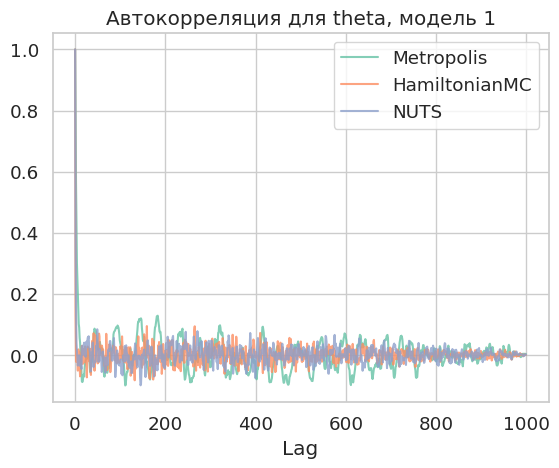

ESS (Metropolis) для theta: 141.17 (14.1%)
ESS (HamiltonianMC) для theta: 806.10 (80.6%)
ESS (NUTS) для theta: 476.94 (47.7%)


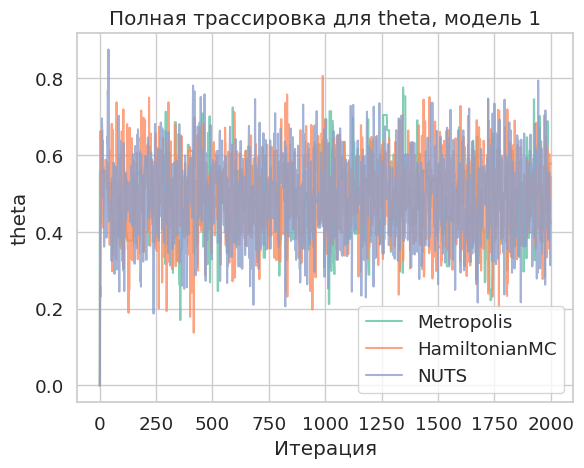

Metropolis: mean=0.4899 при истинном mean_apost=0.4889, var=0.0110 при истинном var_apost=0.0099
HamiltonianMC: mean=0.4899 при истинном mean_apost=0.4889, var=0.0090 при истинном var_apost=0.0099
NUTS: mean=0.4881 при истинном mean_apost=0.4889, var=0.0094 при истинном var_apost=0.0099


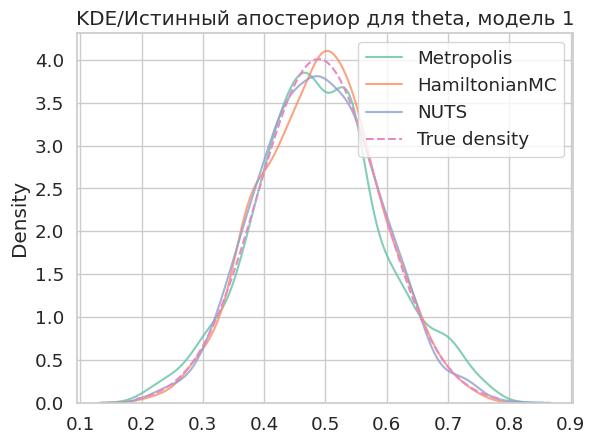


Модель 2


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [theta_1, theta_2]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [theta_1, theta_2]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


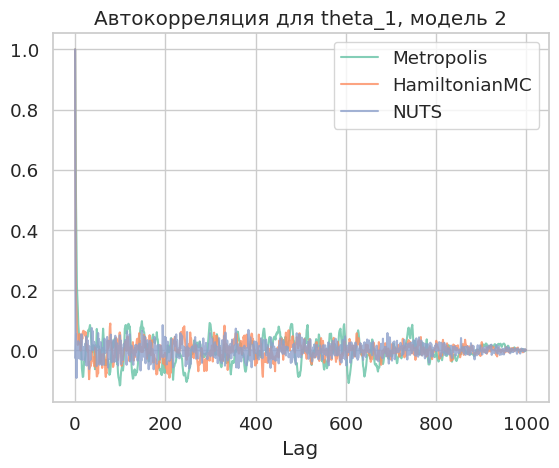

ESS (Metropolis) для theta_1: 166.82 (16.7%)
ESS (HamiltonianMC) для theta_1: 310.33 (31.0%)
ESS (NUTS) для theta_1: 1004.15 (100.4%)


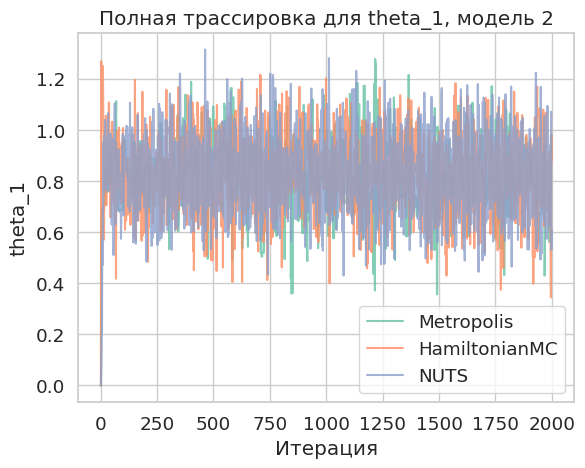

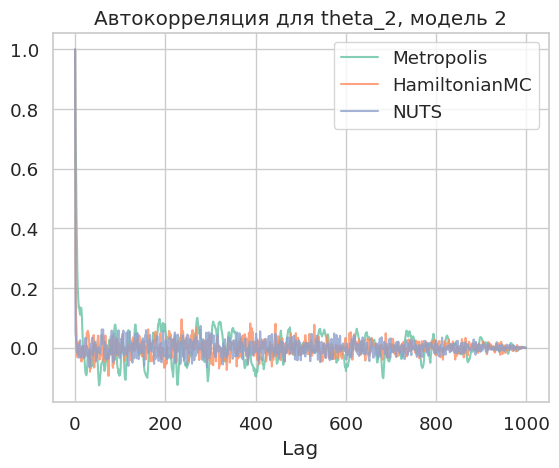

ESS (Metropolis) для theta_2: 108.44 (10.8%)
ESS (HamiltonianMC) для theta_2: 542.36 (54.2%)
ESS (NUTS) для theta_2: 927.01 (92.7%)


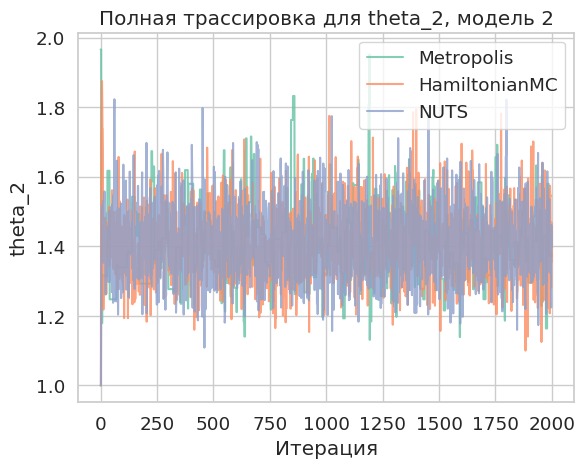


Модель 3


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [theta_1, theta_2]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [theta_1, theta_2]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


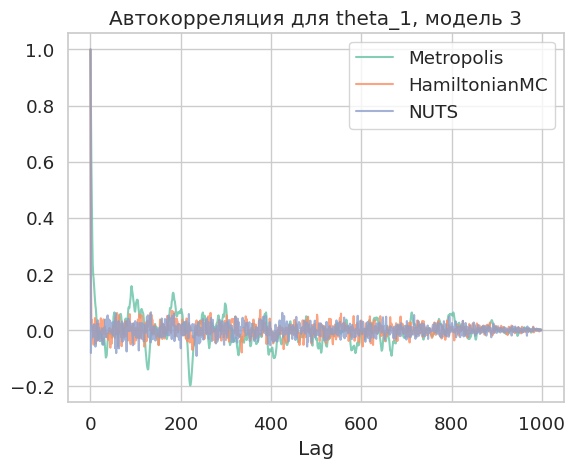

ESS (Metropolis) для theta_1: 126.32 (12.6%)
ESS (HamiltonianMC) для theta_1: 662.32 (66.2%)
ESS (NUTS) для theta_1: 1179.94 (118.0%)


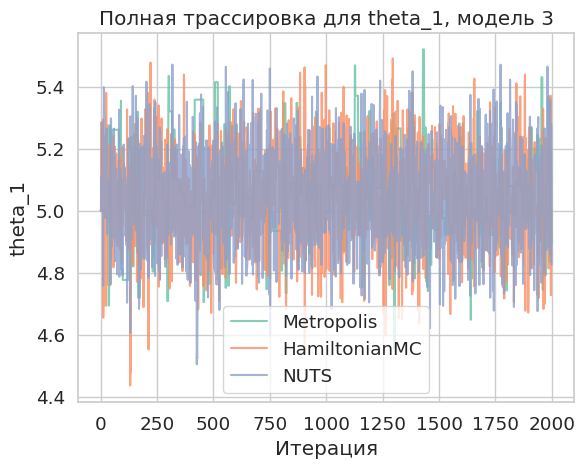

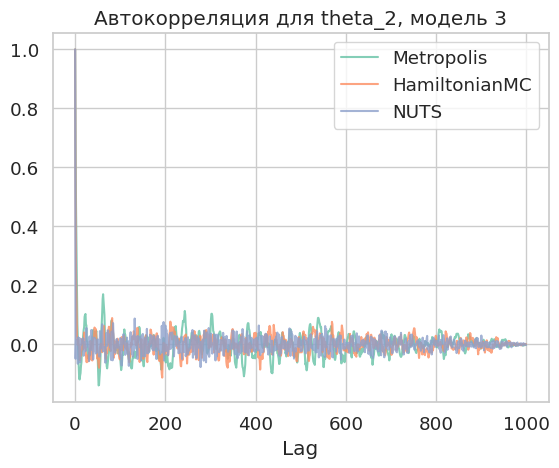

ESS (Metropolis) для theta_2: 229.48 (22.9%)
ESS (HamiltonianMC) для theta_2: 362.39 (36.2%)
ESS (NUTS) для theta_2: 1078.47 (107.8%)


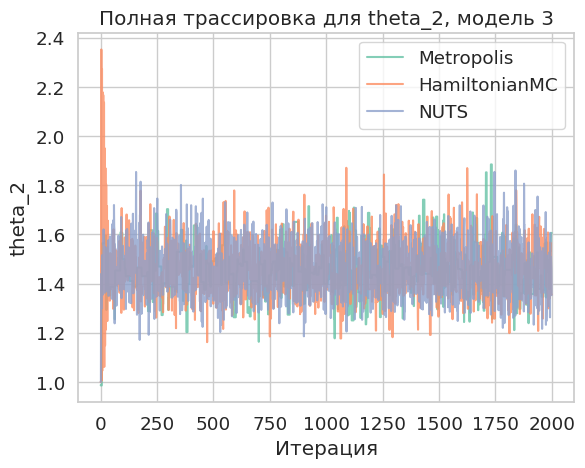

In [116]:
n = 100
samplers = [pm.Metropolis, pm.HamiltonianMC, pm.NUTS]

for model_idx in [1, 2, 3]:
    observed_data = get_sample(model_idx, n)
    print(f"\nМодель {model_idx}")
    traces = {}
    for sampler in samplers:
        _, trace = get_model(model_idx, observed_data, sampler)
        traces[sampler.__name__] = trace

    first_trace = traces[samplers[0].__name__]
    param_names = list(first_trace.posterior.data_vars)

    for param in param_names:
        #автокорреляции
        fig, ax = plt.subplots()
        for name, trace in traces.items():
            samples = trace.posterior[param].values.flatten()
            ac = az.autocorr(samples)
            ax.plot(ac, label=name, alpha=0.8)
        ax.set_title(f"Автокорреляция для {param}, модель {model_idx}")
        ax.set_xlabel("Lag")
        ax.legend()
        plt.show()

        #ess
        ess_vals = {}
        for name, trace in traces.items():
            ess = az.ess(trace)[param].values
            total = trace.posterior.draw.size
            ess_vals[name] = (ess, ess / total * 100)
            print(f"ESS ({name}) для {param}: {ess:.2f} ({ess_vals[name][1]:.1f}%)")

        #трассировка
        fig, ax = plt.subplots()
        for name, trace in traces.items():
            warmup = trace.warmup_posterior[param].values.flatten()
            post = trace.posterior[param].values.flatten()
            full = np.concatenate([warmup, post])
            ax.plot(full, label=name, alpha=0.8)
        ax.set_title(f"Полная трассировка для {param}, модель {model_idx}")
        ax.set_xlabel("Итерация")
        ax.set_ylabel(param)
        ax.legend()
        plt.show()

        #если модель 1
        if model_idx == 1 and param == 'theta':
            sum_x = np.sum(observed_data)
            ## параметры для апотериора истинного
            mu_post = sum_x / (n + 1)
            sigma_post = np.sqrt(1 / (n + 1))

            for name, trace in traces.items():
                post = trace.posterior[param].values.flatten()
                m, v = np.mean(post), np.var(post)
                print(f"{name}: mean={m:.4f} при истинном mean_apost={mu_post:.4f}, var={v:.4f} при истинном var_apost={sigma_post**2:.4f}")

            fig, ax = plt.subplots()
            x = np.linspace(mu_post - 3*sigma_post, mu_post + 3*sigma_post, 200)
            true_dens = sps.norm.pdf(x, mu_post, sigma_post)
            for name, trace in traces.items():
                post = trace.posterior[param].values.flatten()
                sns.kdeplot(post, ax=ax, label=name, alpha=0.8)
            ax.plot(x, true_dens, linestyle='--', label='True density')
            ax.set_title(f"KDE/Истинный апостериор для theta, модель 1")
            ax.legend()
            plt.show()


Сделайте выводы

Есть корреляции на околонулевых лагах - что ожидаемо из вида схем; затем они потихоньку затихают, примерно одинаково на всех схемах

По трассировке все очень похоже, кроме первых шагов разогрева, когда модели еще более хаотичны, что видно на третьей модели у HamiltonianMC и просто на второй модели, далее хаотичный шум

По ESS:

Metropolis плох на всех моделях, ~10-15%

HamiltonianMC хорош на первой модели ~80%, однако не так хорош на остальных ~30-60%

NUTS не хочень хорош на первой модели ~50%, однако очень крут на остальных ~100%

Апостериор на первой моделе:

На параметрах все сэмплеры примерно близки, но сравнение по точности оценок такое

NUTS > HamiltonianMC > Metropolis, и у Metropolis самый не-гладкий KDE

**Итого:**

В этой задаче гамильтонова динамика оказалось лучше, NUTS может значительно улучшить результат HamiltonianMC

__________________
## Задача 3

Исследуем, как методы MCMC работают с многомодальными распределениями. Типичный пример многомодального распределения &mdash; смесь распределений. В частности, на смеси распределений основан метод k-means.

Рассмотрим смесь трех одномерных нормальных распределений. Выборку можно сгенерировать следующим способом

In [ ]:
X, _ = make_blobs(n_samples=300, n_features=1, centers=[[-7], [0], [15]])

Допишите заданную ниже модель, указав параметры распределений и семплирования

In [137]:
def get_model(X_blob, step, chains_cnt):
    with pm.Model() as model:
        # априорное распределение параметров компонент
        theta_1 = pm.Normal('theta_1', 0, 45)
        theta_2 = pm.Normal('theta_2', 0, 45)
        theta_3 = pm.Normal('theta_3', 0, 45)

        # априорное распределение вероятностей компонент
        pi = pm.Dirichlet('pi', a=np.ones(3))

        # распределения компонент
        comp1 = pm.Normal.dist(mu=theta_1)
        comp2 = pm.Normal.dist(mu=theta_2)
        comp3 = pm.Normal.dist(mu=theta_3)

        # сама смесь
        mix = pm.Mixture(
            'mix', w=pi, comp_dists=[comp1, comp2, comp3], observed=X_blob.ravel()
        )

        trace = pm.sample(2000, chains=chains_cnt, step=step(),
                          discard_tuned_samples=False, progressbar=False)
    return model, trace

Исследуйте, как зависит апостериорное распределение компонент $\theta$ в зависимости от метода семплирования и количества цепей (от 1 до 4).

Используйте функцию `pm.plot_posterior` для визуализации апостериорного распределения и `pm.plot_trace` для визуализации результатов в разрезе каждой цепи.

Metropolis, chains_cnt=1


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
>Metropolis: [theta_3]
>Metropolis: [pi]
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


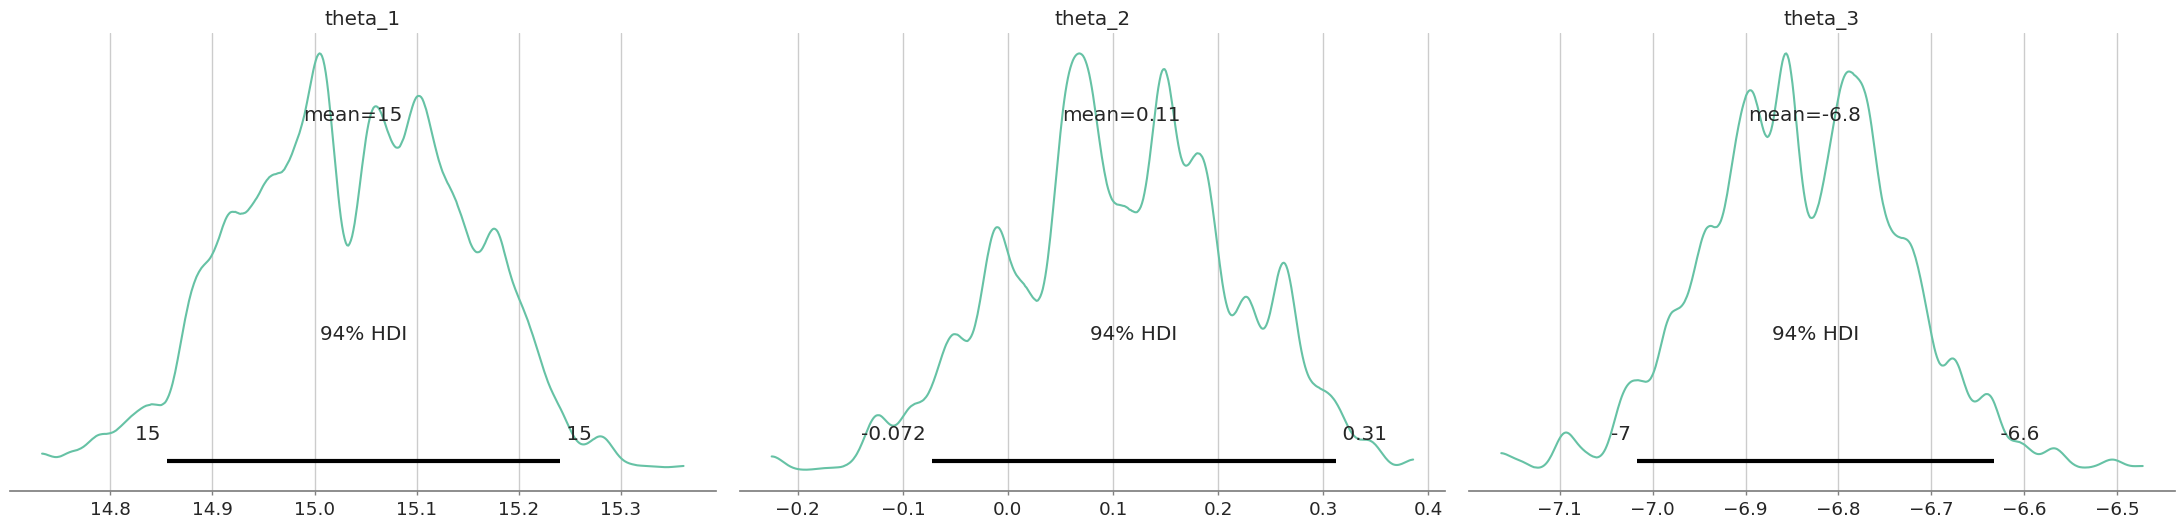

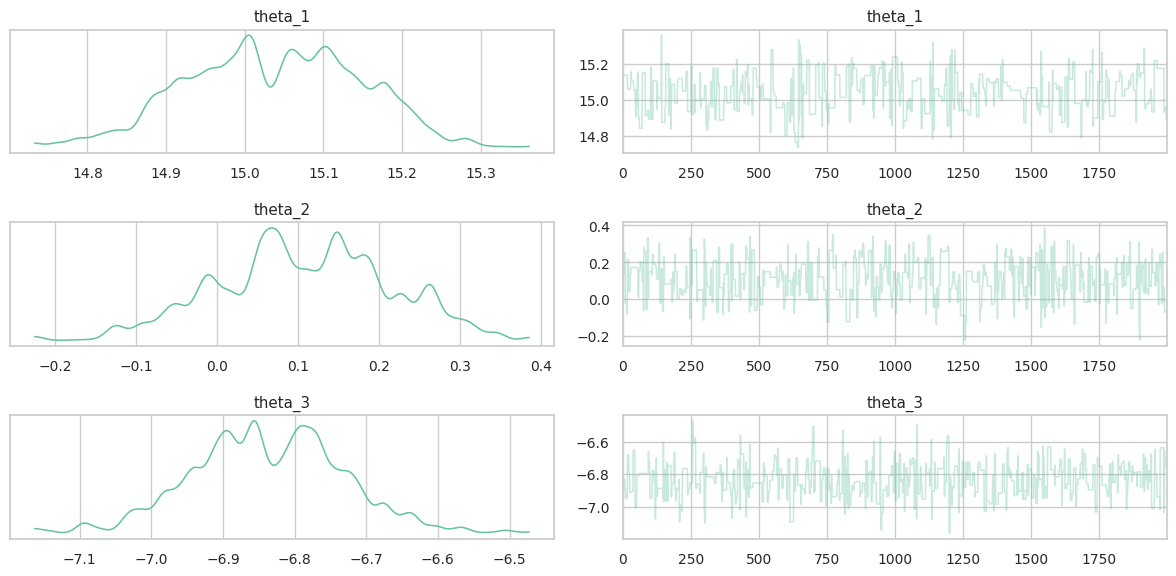

Metropolis, chains_cnt=2


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
>Metropolis: [theta_3]
>Metropolis: [pi]
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https:

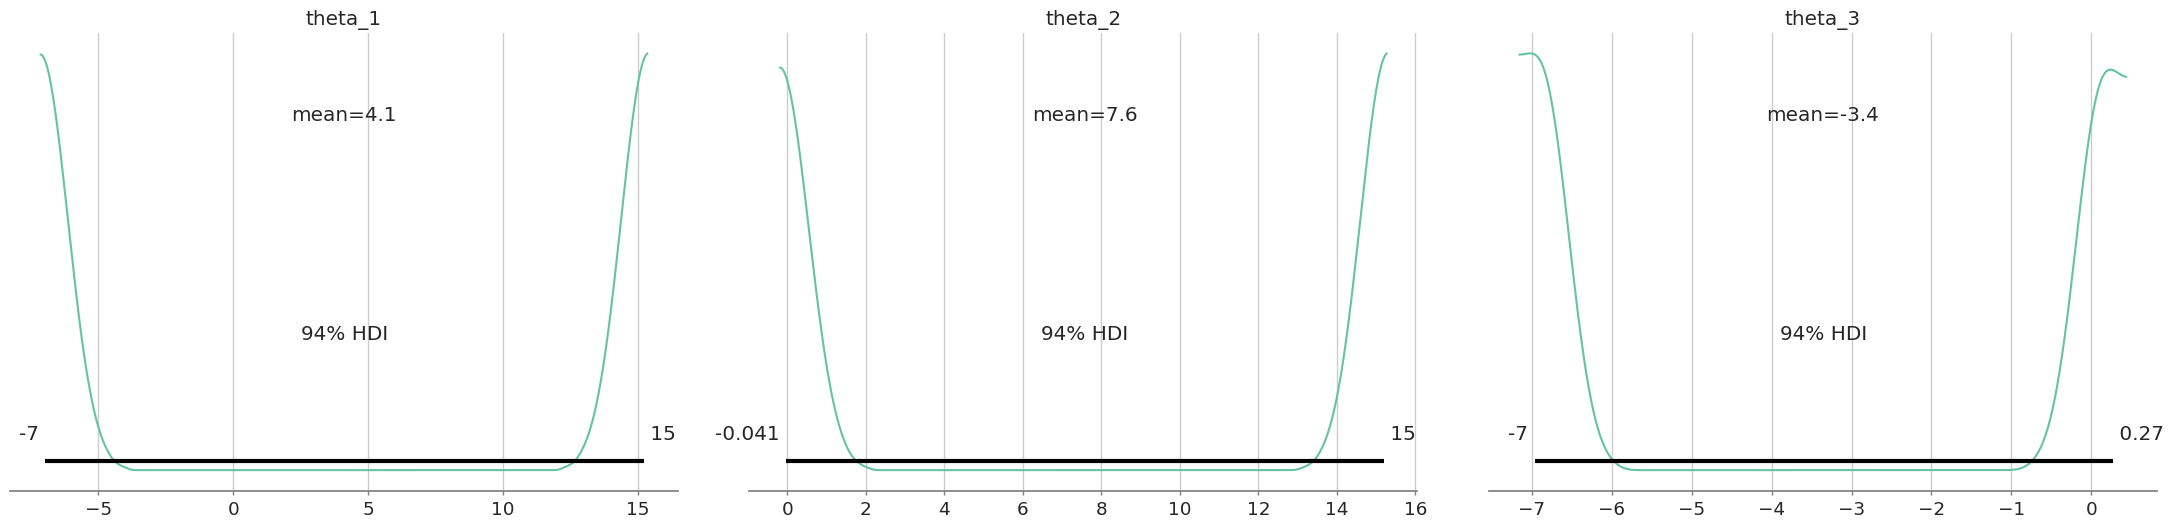

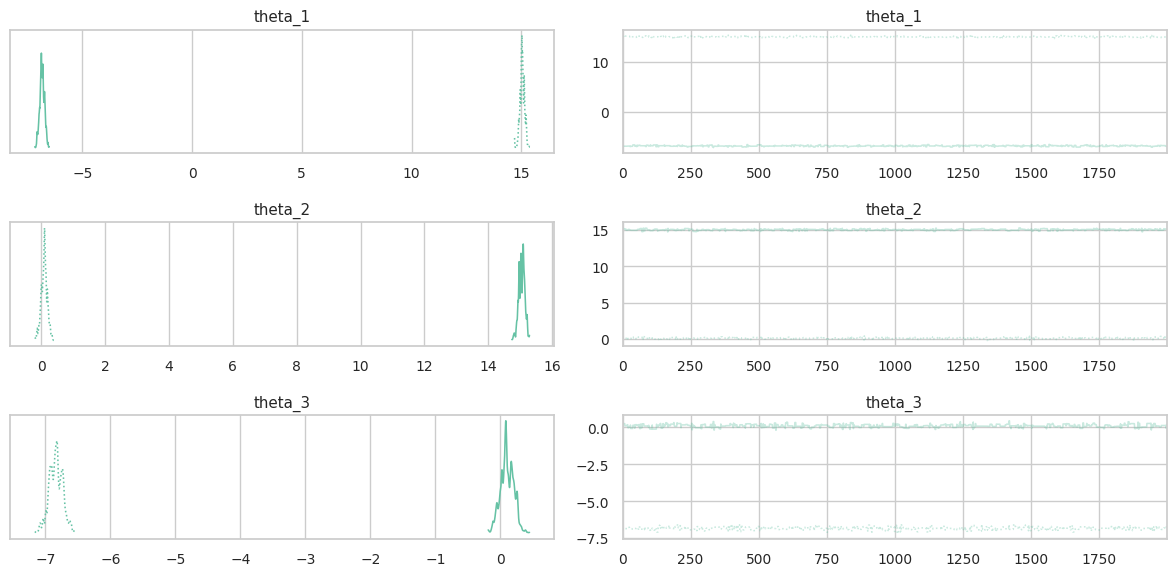

Metropolis, chains_cnt=3


Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
>Metropolis: [theta_3]
>Metropolis: [pi]
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org

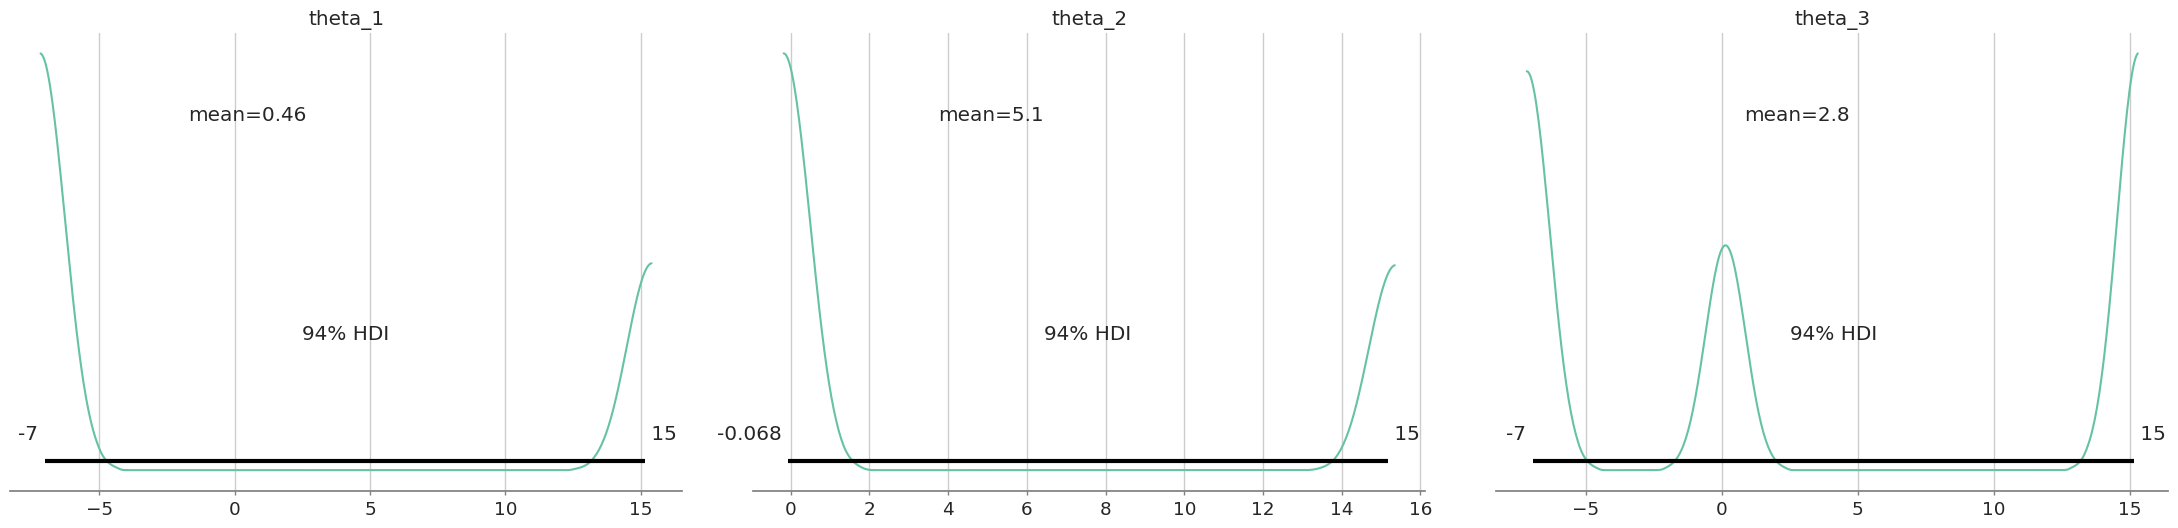

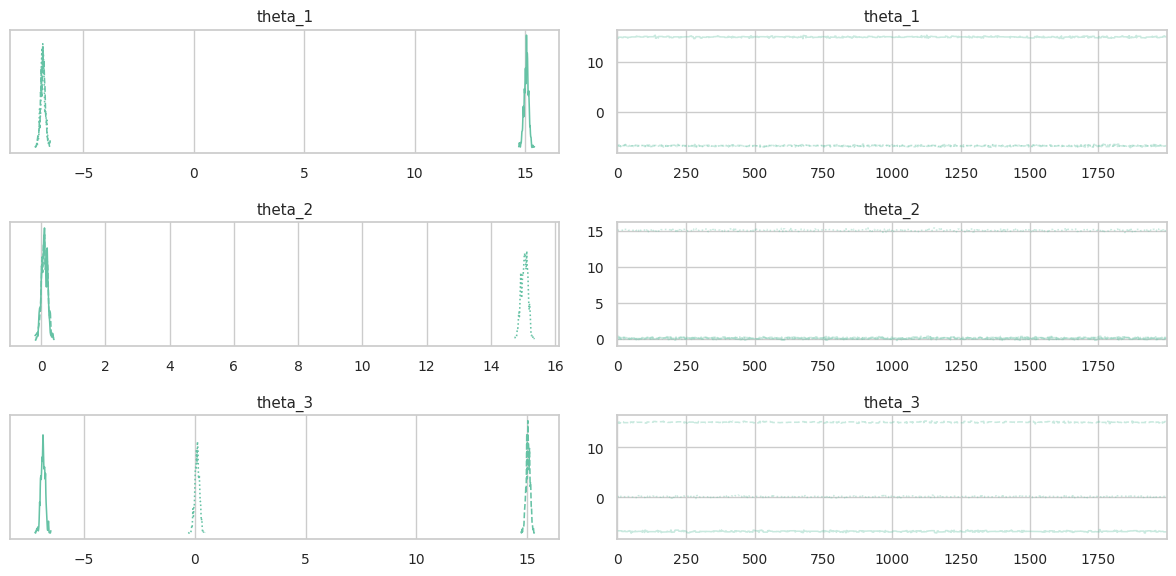

HamiltonianMC, chains_cnt=1


Sequential sampling (1 chains in 1 job)
HamiltonianMC: [theta_1, theta_2, theta_3, pi]
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


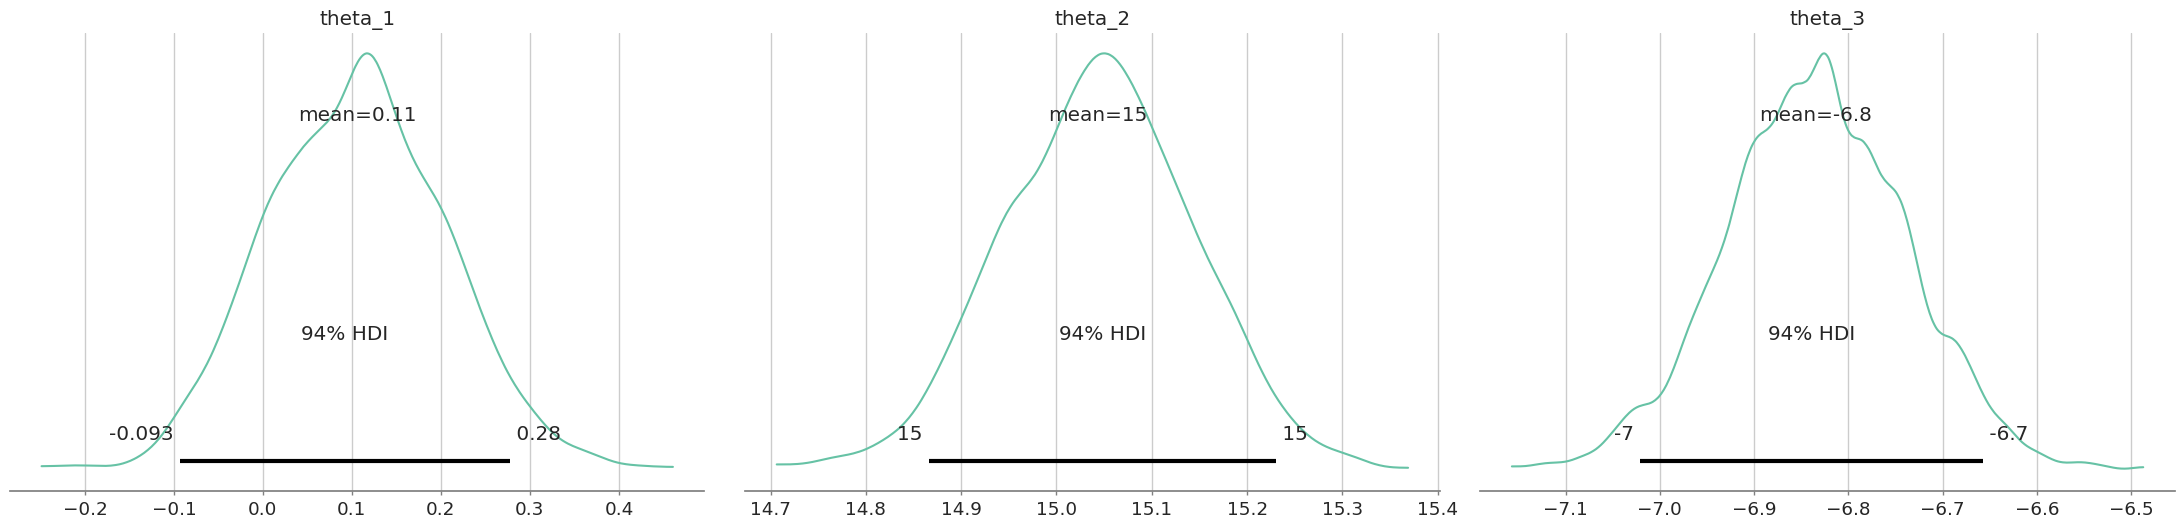

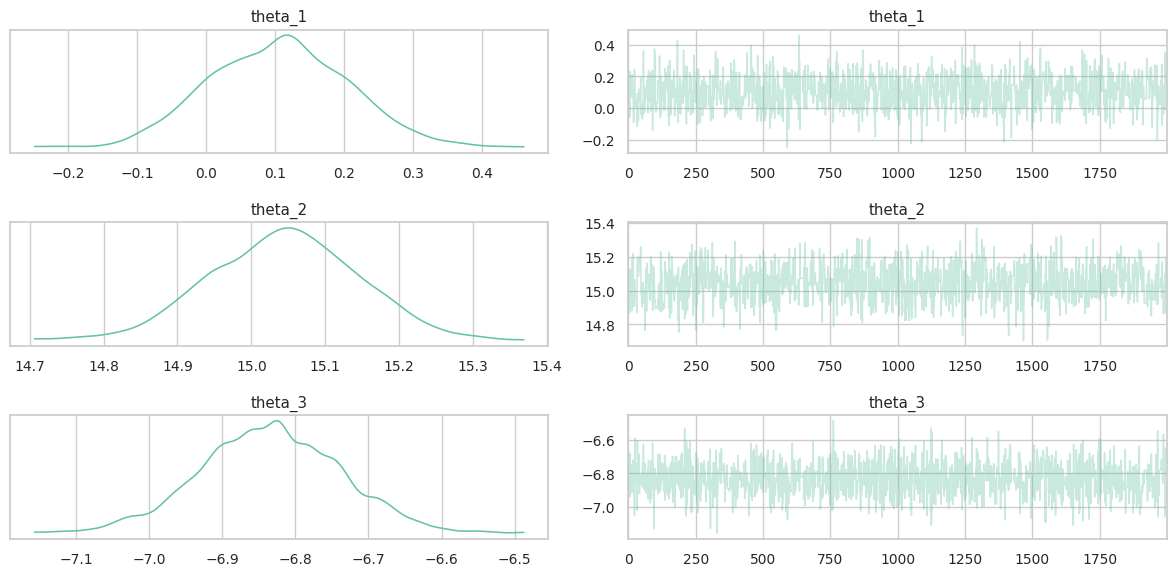

HamiltonianMC, chains_cnt=2


Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [theta_1, theta_2, theta_3, pi]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


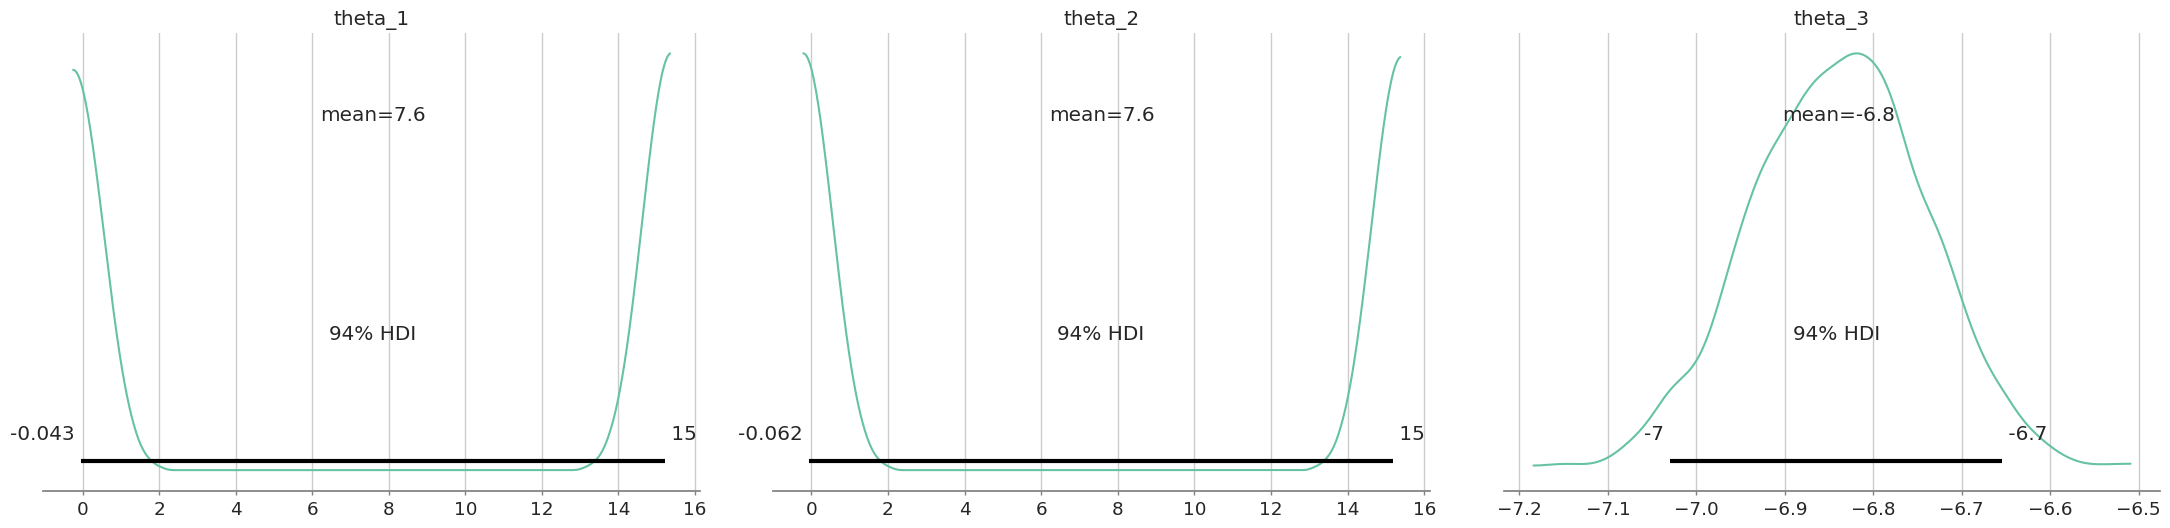

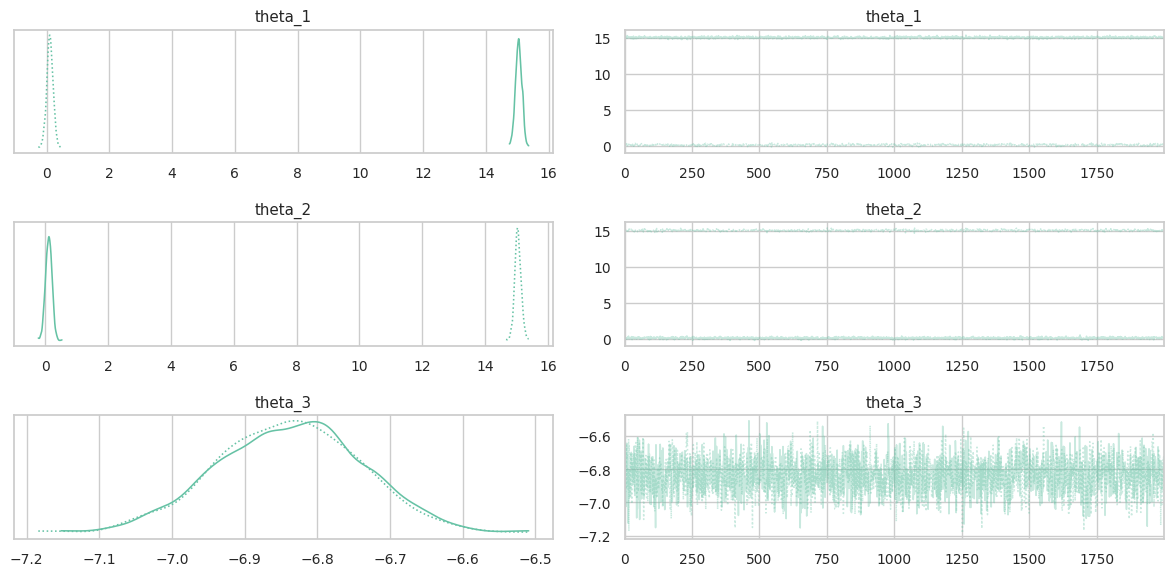

HamiltonianMC, chains_cnt=3


Multiprocess sampling (3 chains in 3 jobs)
HamiltonianMC: [theta_1, theta_2, theta_3, pi]
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/hmc/hmc.py:168: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


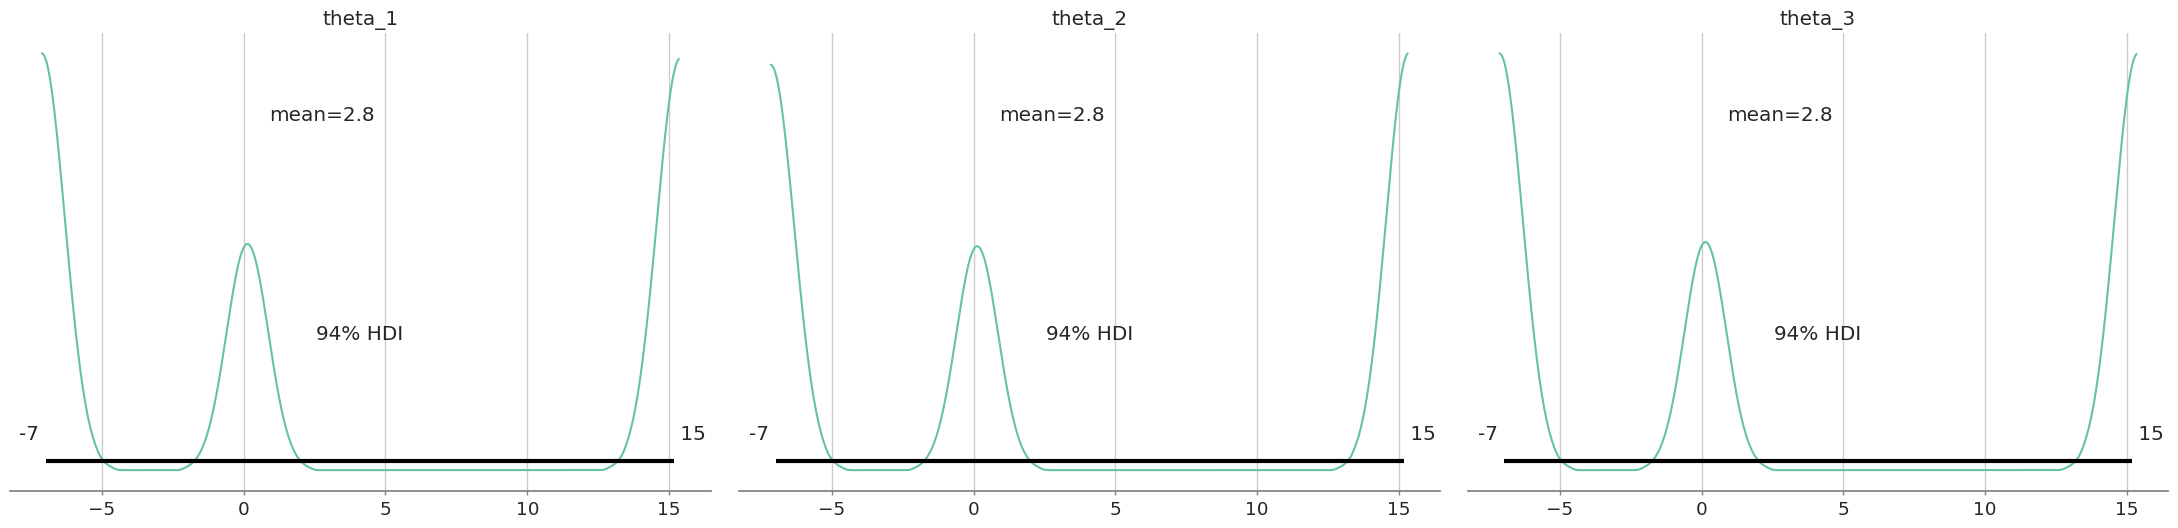

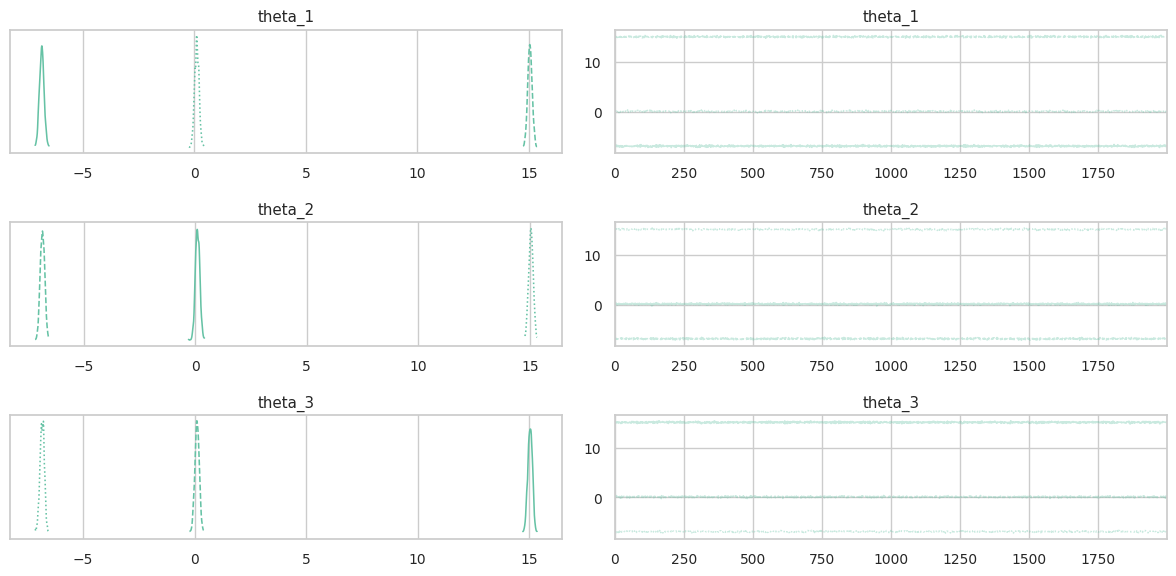

NUTS, chains_cnt=1


Sequential sampling (1 chains in 1 job)
NUTS: [theta_1, theta_2, theta_3, pi]
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


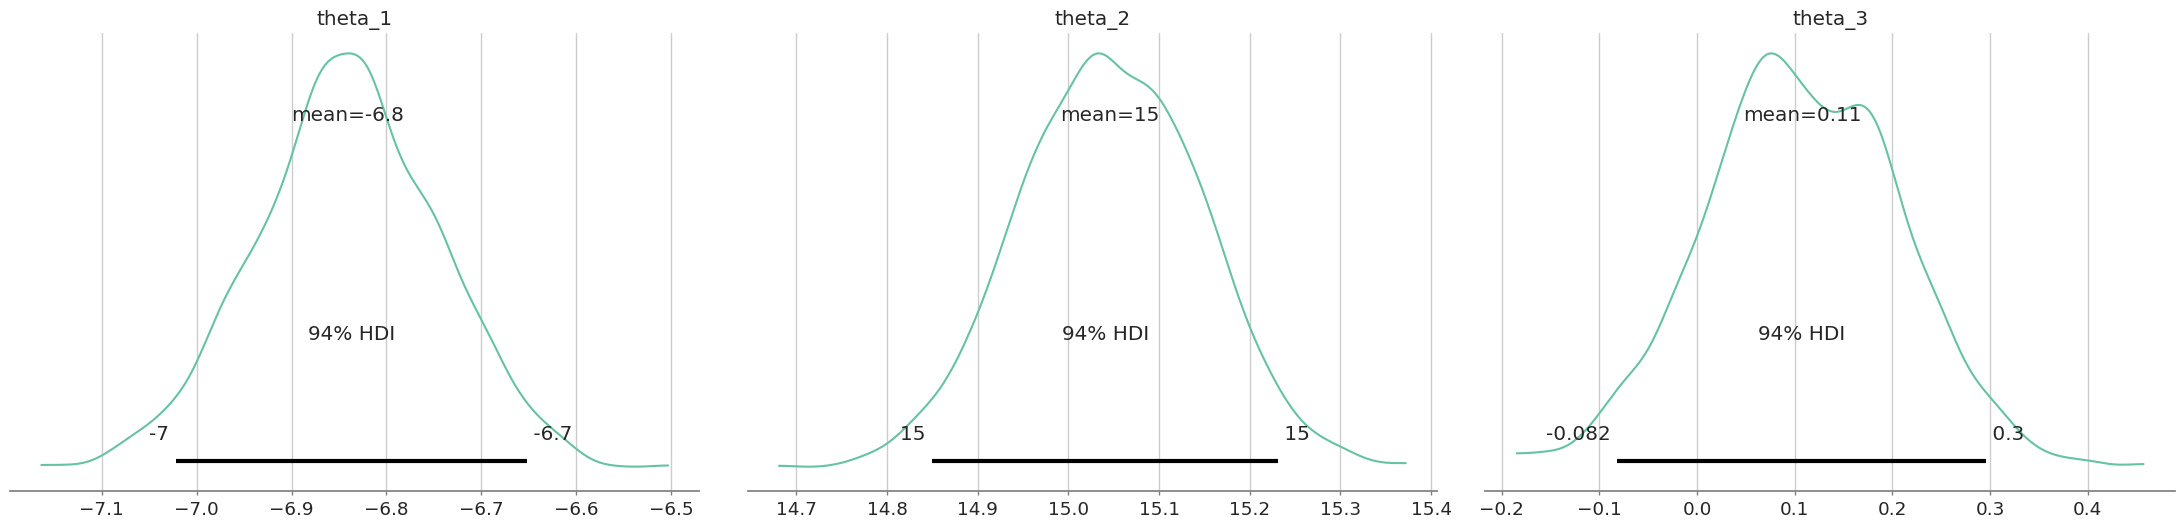

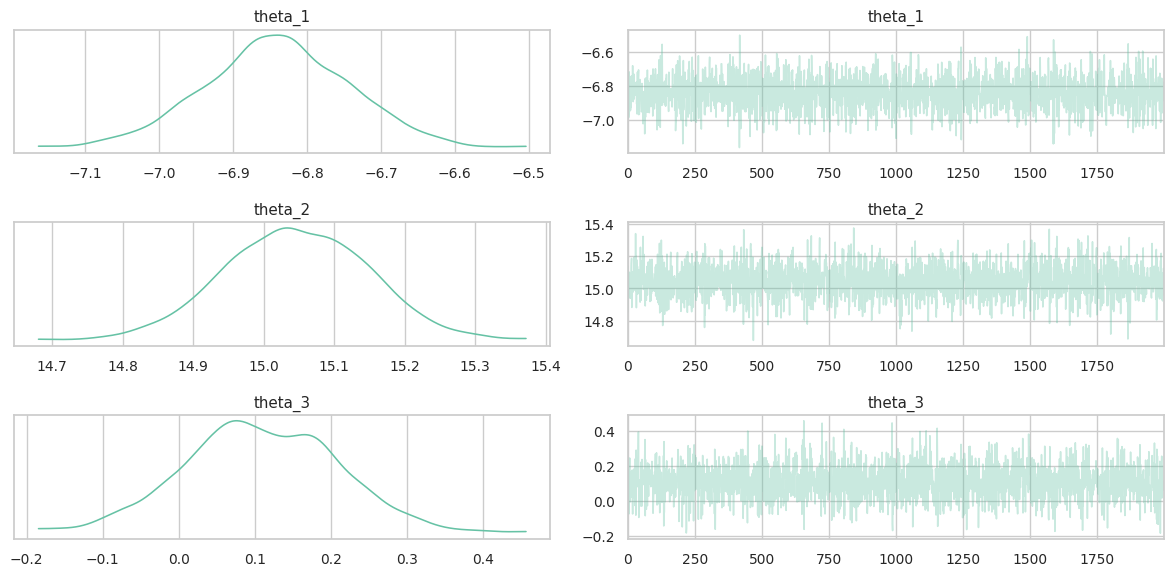

NUTS, chains_cnt=2


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_1, theta_2, theta_3, pi]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


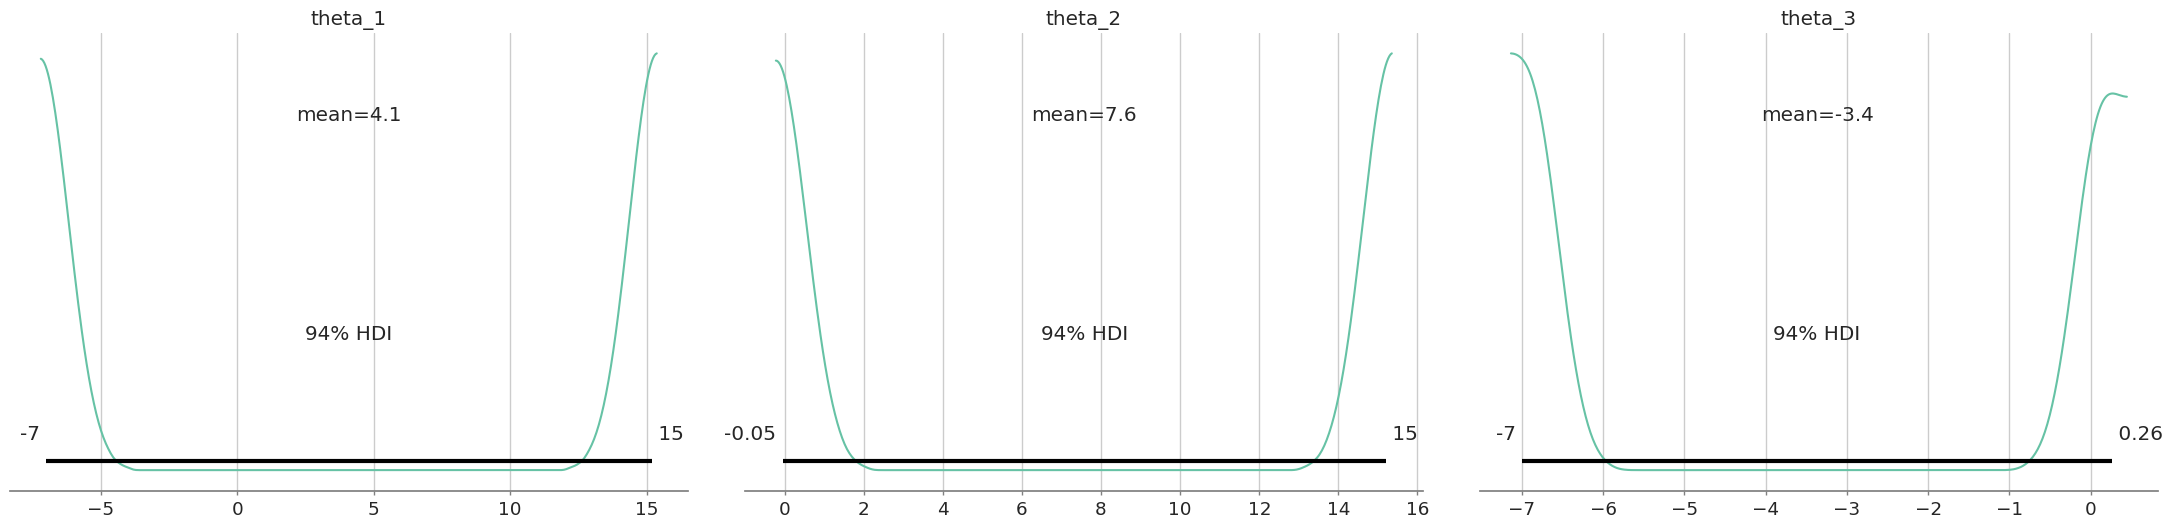

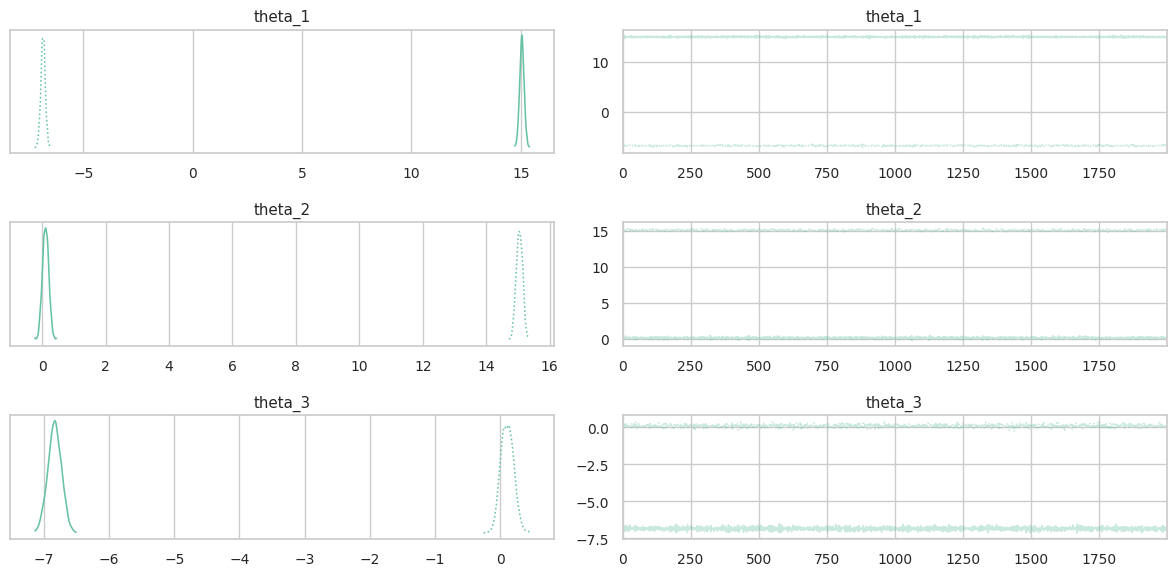

NUTS, chains_cnt=3


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta_1, theta_2, theta_3, pi]
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


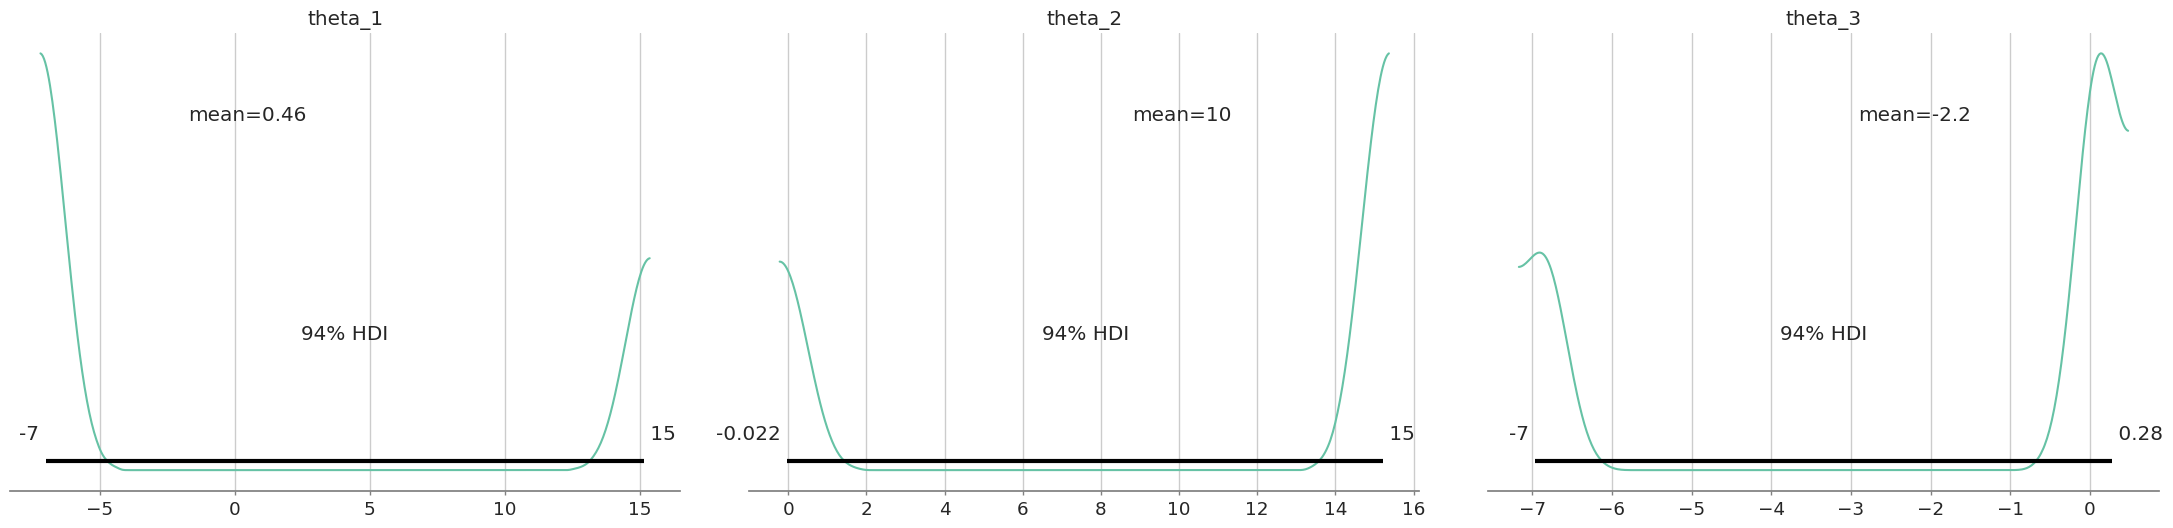

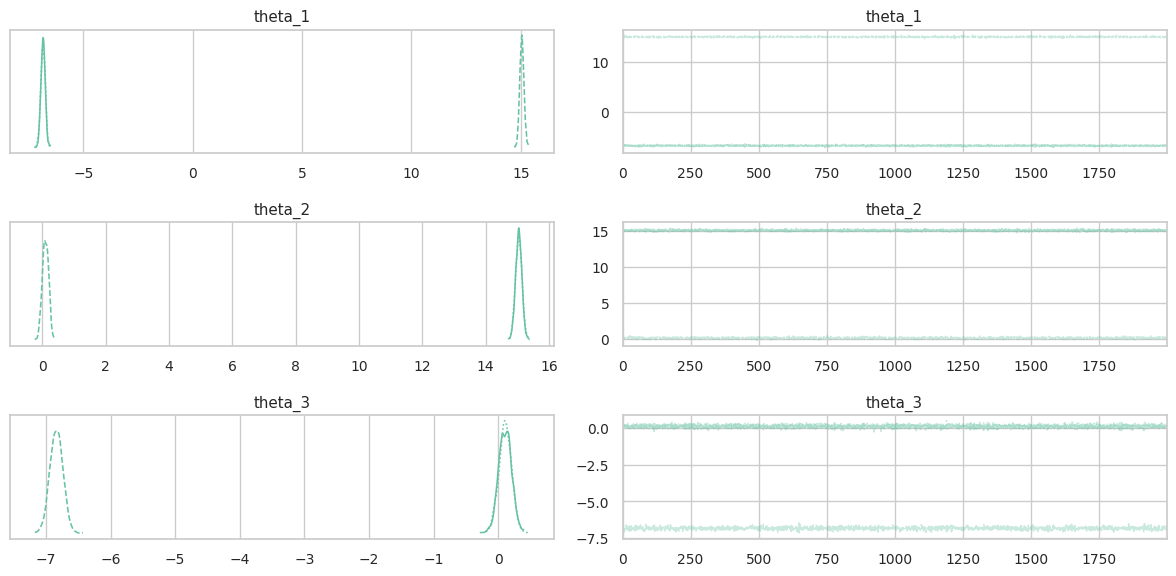

In [138]:
samplers = [pm.Metropolis, pm.HamiltonianMC, pm.NUTS]

for sampler in samplers:
    for chains_cnt in range(1, 4):
        print(f"{sampler.__name__}, chains_cnt={chains_cnt}")
        model, trace = get_model(X, sampler, chains_cnt)
        pm.plot_posterior(trace, var_names=["theta_1", "theta_2", "theta_3"])
        plt.tight_layout()
        plt.show()
        
        pm.plot_trace(trace, var_names=["theta_1", "theta_2", "theta_3"])
        plt.tight_layout()
        plt.show()

Можно ли как-то исправить возникающий эффект при использовании нескольких цепей?

Если поставить априорное распределение на $\theta$ одинаковым то у нас будут перемешиваться случайно в каждой из цепей то, какой из $\theta_i$ отвечает за какой из кластеров

На одной цепи еще адекватно работать будет, при большем количестве - нет.

Можно поменять априорное распределение так, чтобы в них зашить различие между параметрами

Сделайте выводы

В случае наличия нескольких компонент в распределении нужно аккуратно подходить к модели. Если мы все таки решили использовать несколько цепей, то нужно сделать так, чтобы параметры дифференцировались к фиксированной компоненте гарантированно, например, заранее поисследовав выборку

Продемонстрирую запуск при смещенных априорах, что там все хорошо сходится:

In [139]:
def get_model(X_blob, step, chains_cnt):
    with pm.Model() as model:
        # априорное распределение параметров компонент
        theta_1 = pm.Normal('theta_1', -10, 5)
        theta_2 = pm.Normal('theta_2', 0, 45)
        theta_3 = pm.Normal('theta_3', 10, 5)

        # априорное распределение вероятностей компонент
        pi = pm.Dirichlet('pi', a=np.ones(3))

        # распределения компонент
        comp1 = pm.Normal.dist(mu=theta_1)
        comp2 = pm.Normal.dist(mu=theta_2)
        comp3 = pm.Normal.dist(mu=theta_3)

        # сама смесь
        mix = pm.Mixture(
            'mix', w=pi, comp_dists=[comp1, comp2, comp3], observed=X_blob.ravel()
        )

        trace = pm.sample(2000, chains=chains_cnt, step=step(),
                          discard_tuned_samples=False, progressbar=False)
    return model, trace

Запуск

Metropolis, chains_cnt=1


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
>Metropolis: [theta_3]
>Metropolis: [pi]
/home/juequ/.local/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


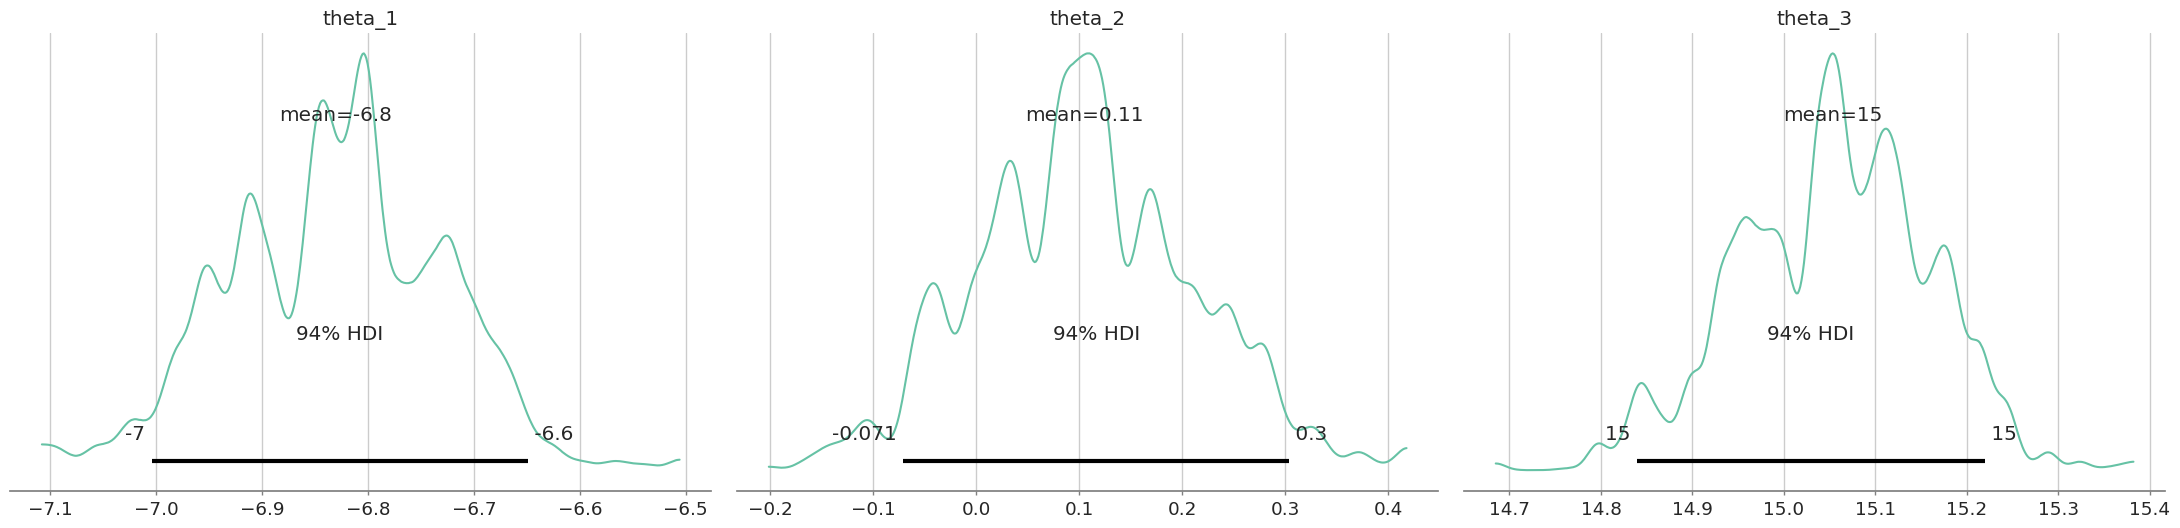

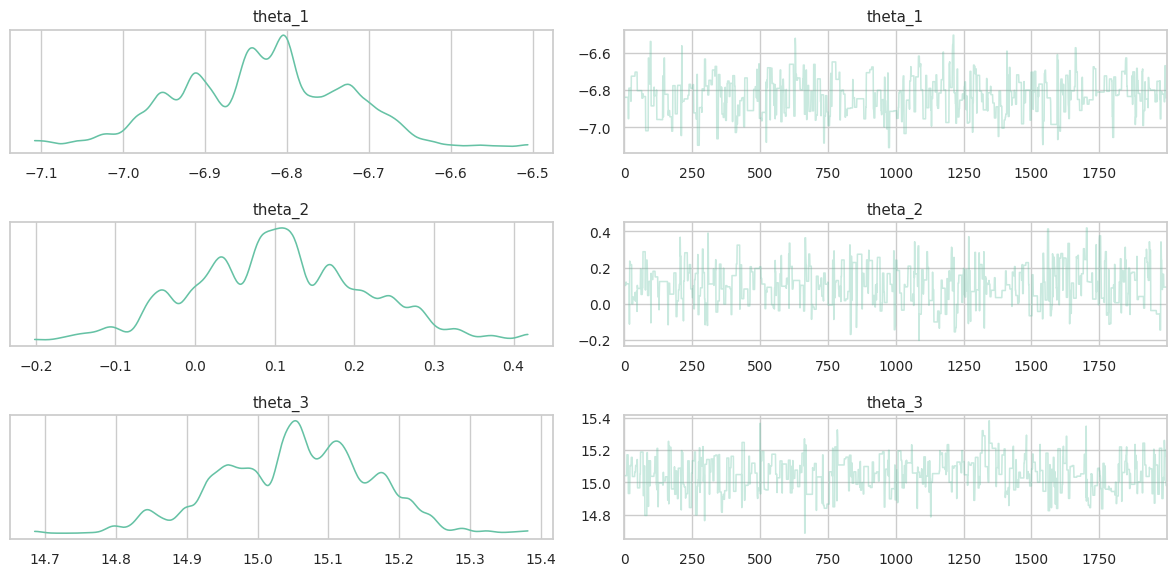

Metropolis, chains_cnt=2


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
>Metropolis: [theta_3]
>Metropolis: [pi]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


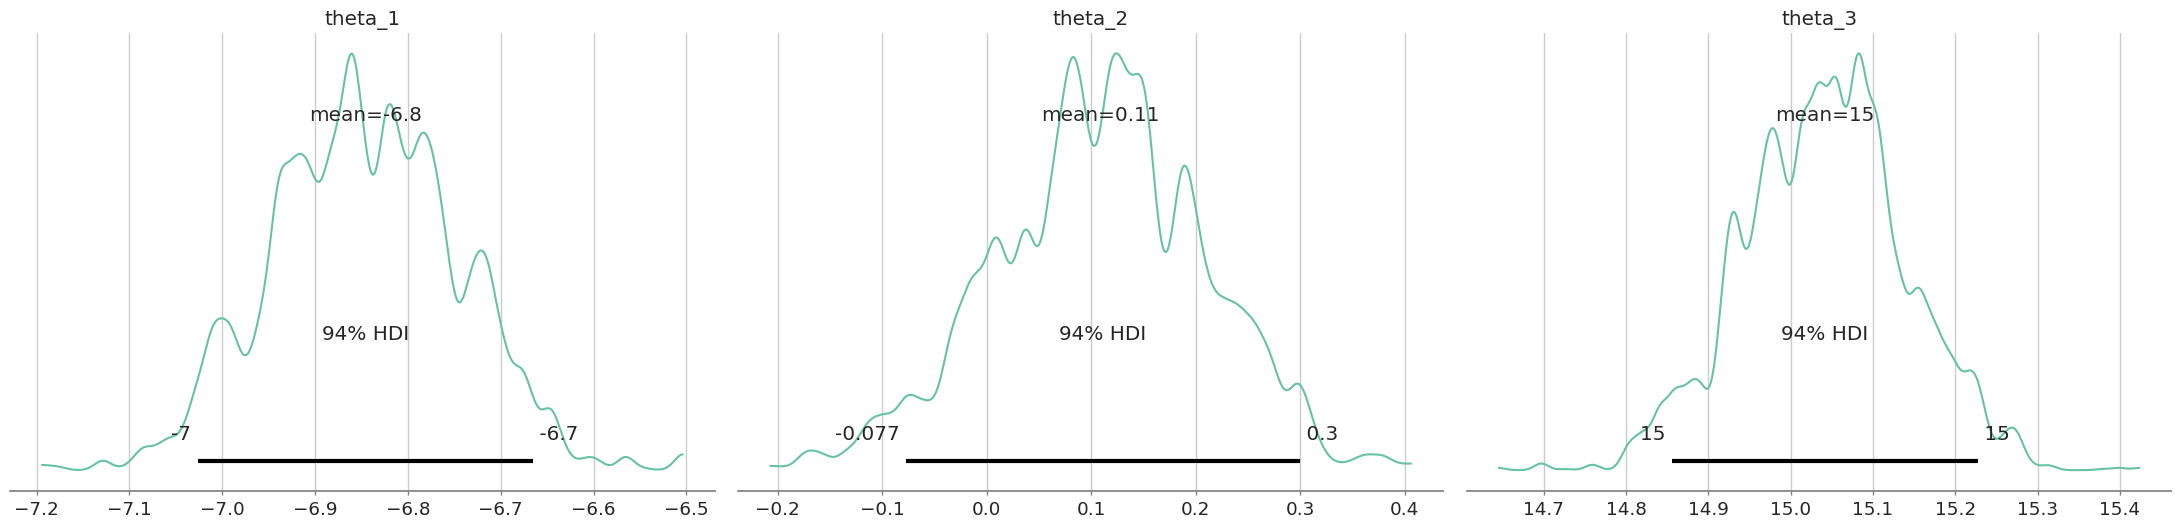

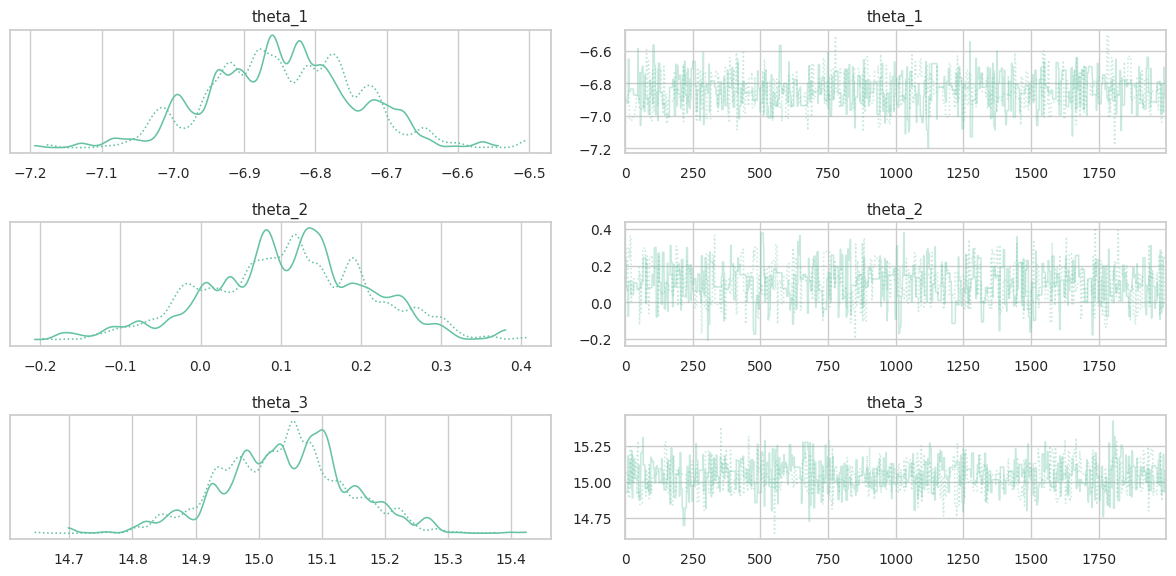

Metropolis, chains_cnt=3


Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_2]
>Metropolis: [theta_3]
>Metropolis: [pi]
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


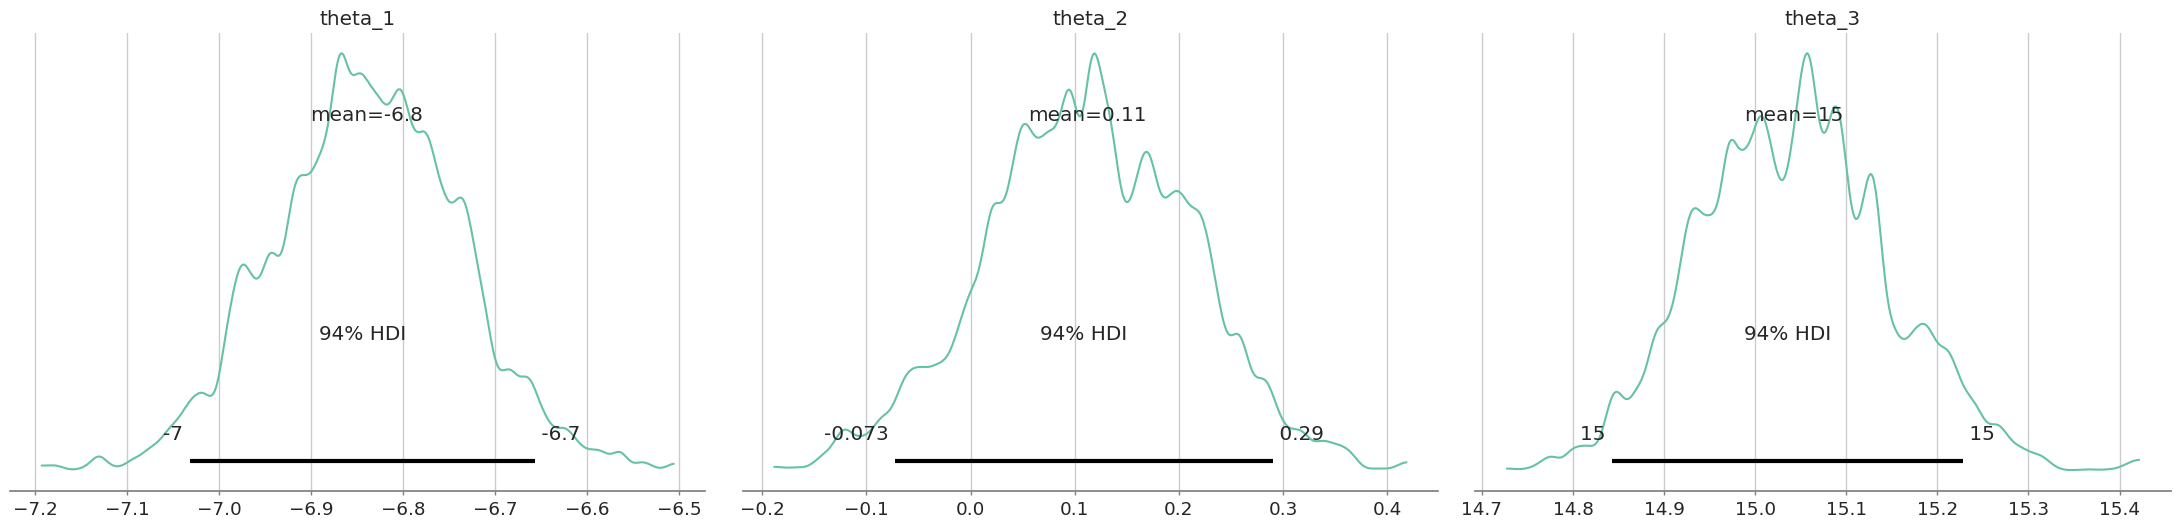

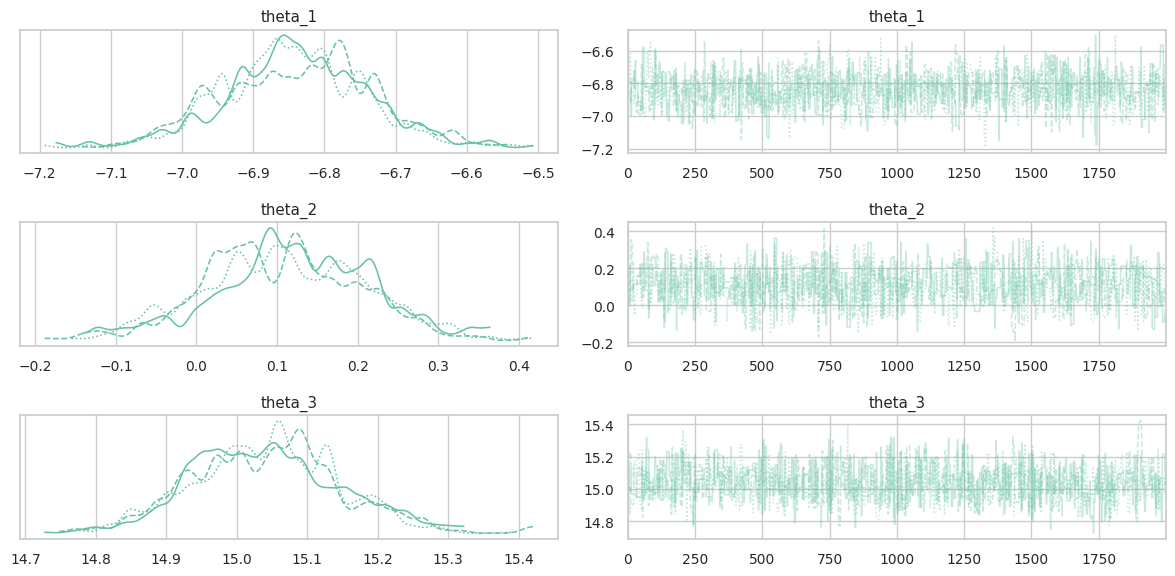

HamiltonianMC, chains_cnt=1


Sequential sampling (1 chains in 1 job)
HamiltonianMC: [theta_1, theta_2, theta_3, pi]
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


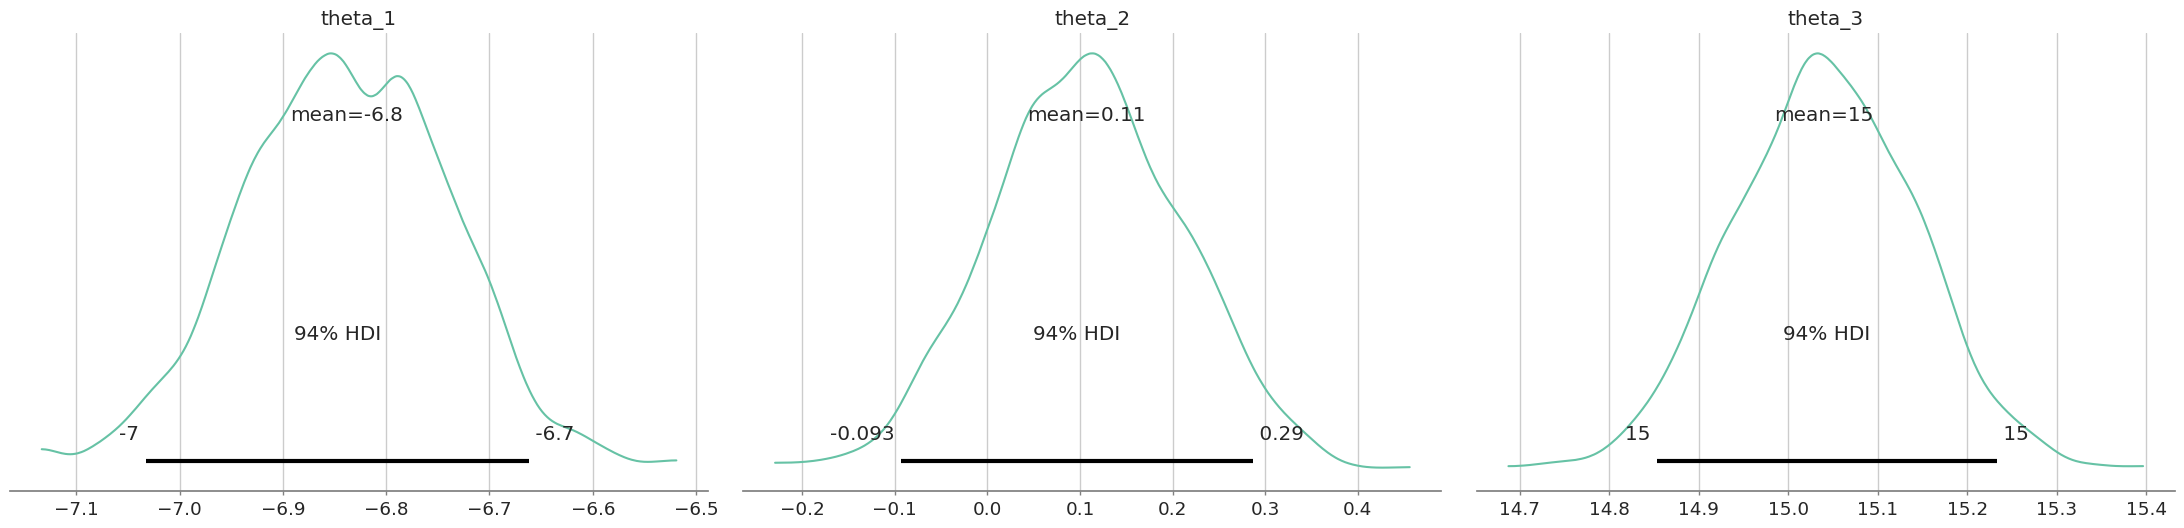

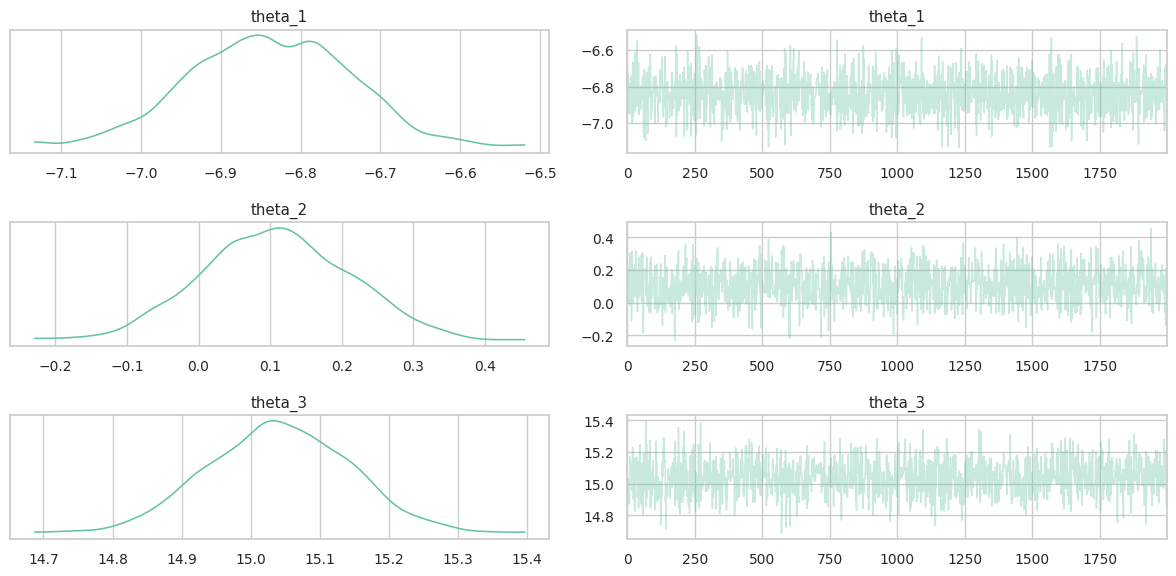

HamiltonianMC, chains_cnt=2


Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [theta_1, theta_2, theta_3, pi]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


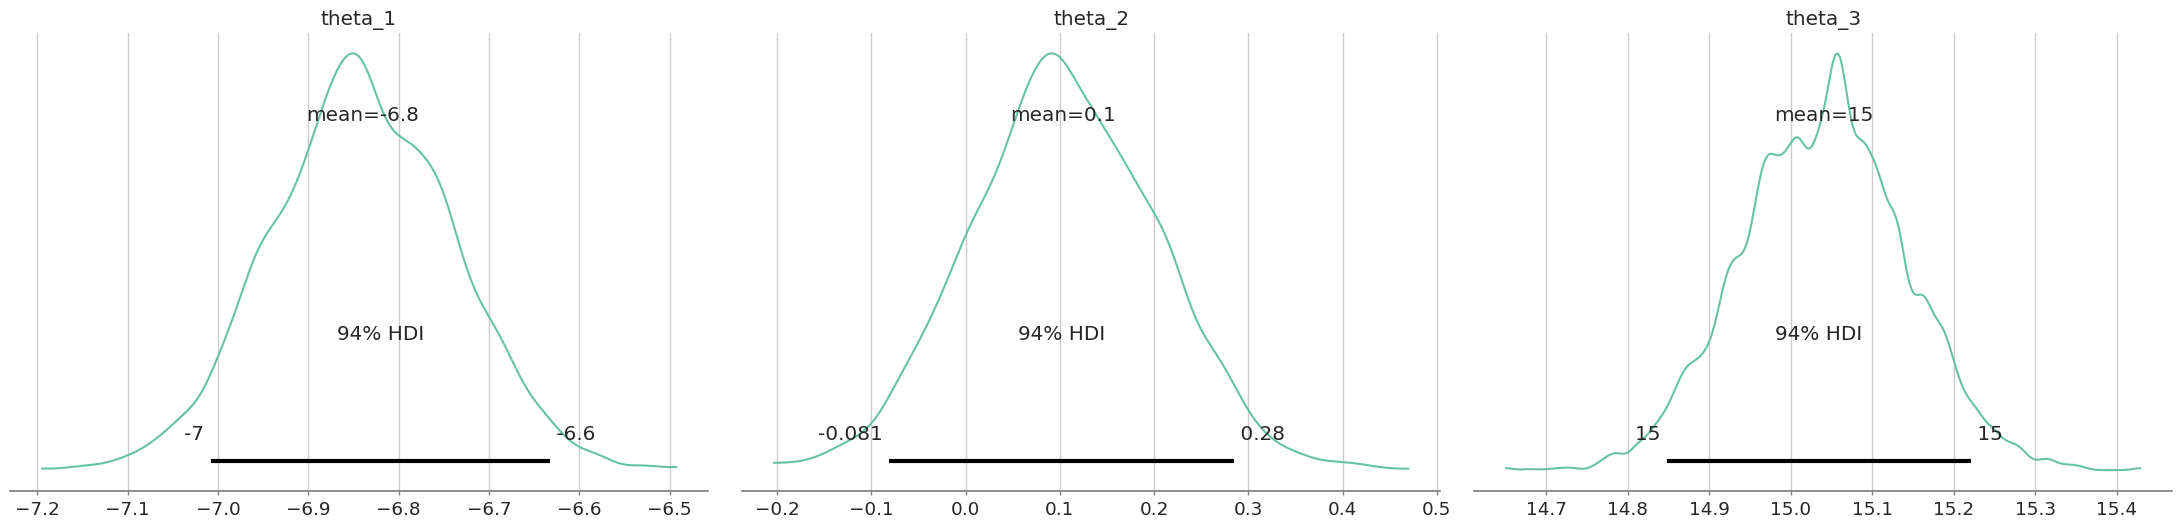

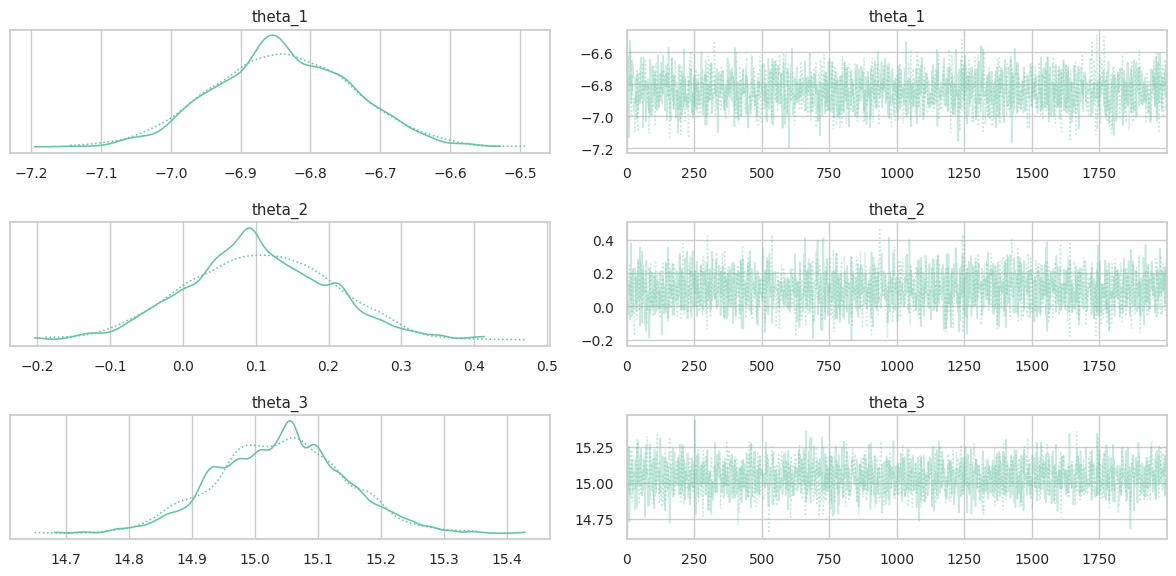

HamiltonianMC, chains_cnt=3


Multiprocess sampling (3 chains in 3 jobs)
HamiltonianMC: [theta_1, theta_2, theta_3, pi]
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


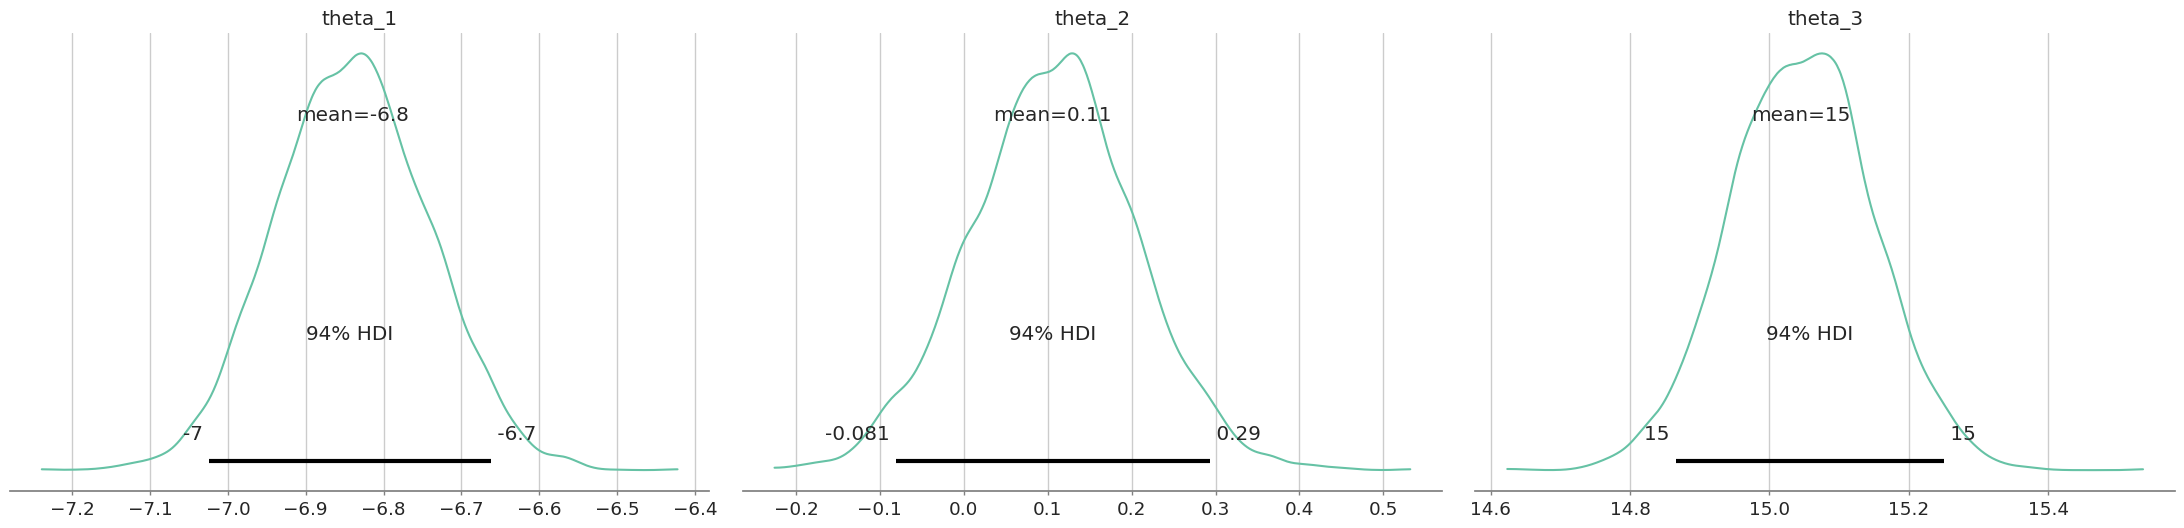

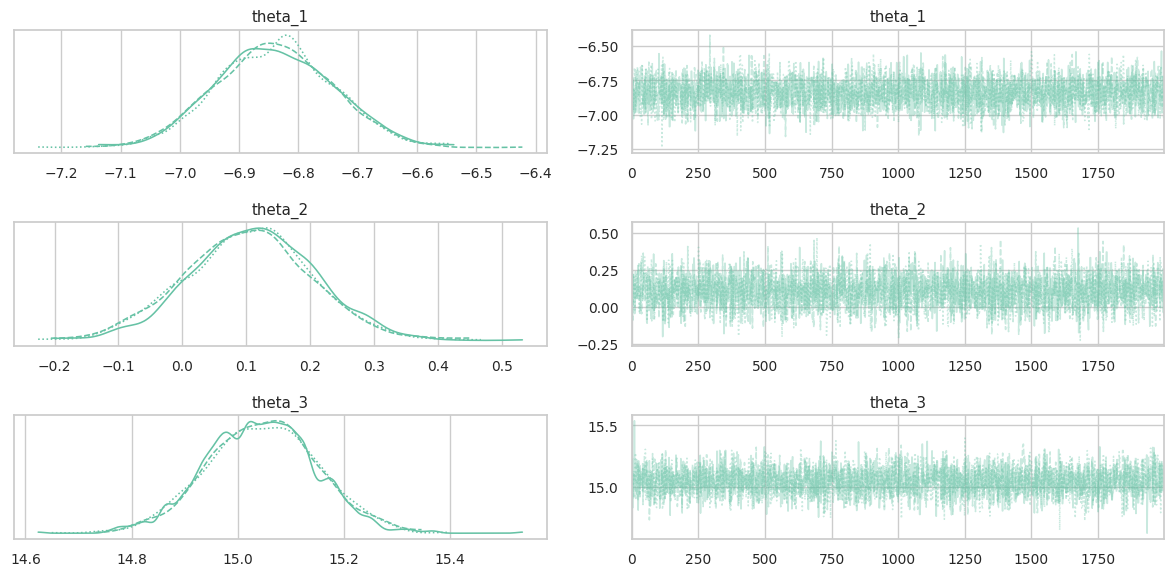

NUTS, chains_cnt=1


Sequential sampling (1 chains in 1 job)
NUTS: [theta_1, theta_2, theta_3, pi]
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


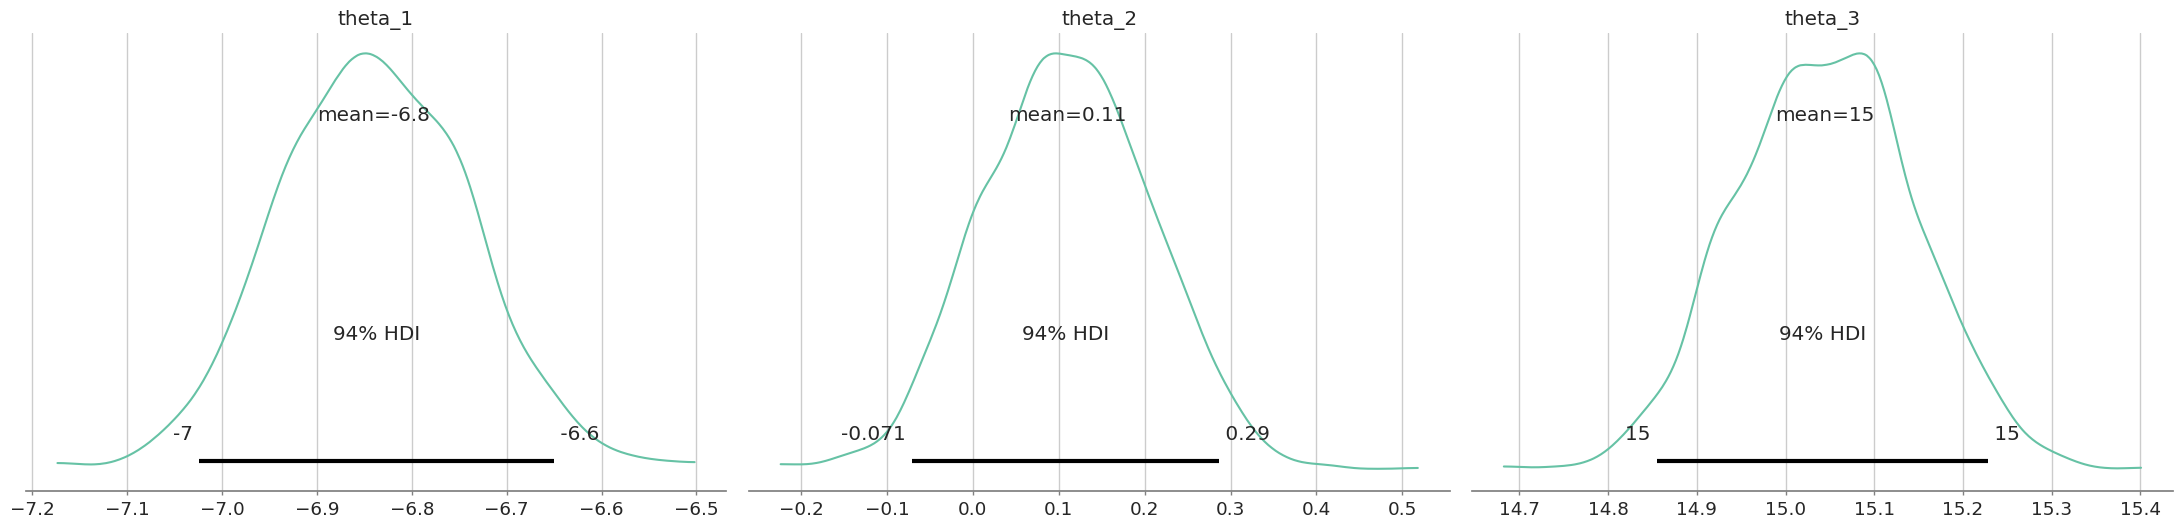

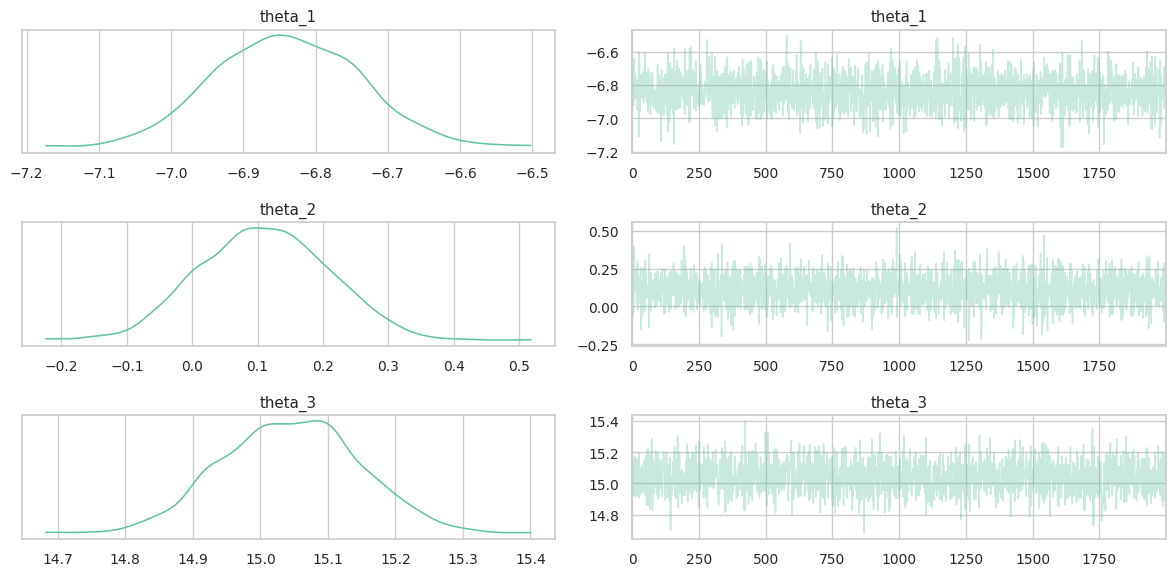

NUTS, chains_cnt=2


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_1, theta_2, theta_3, pi]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


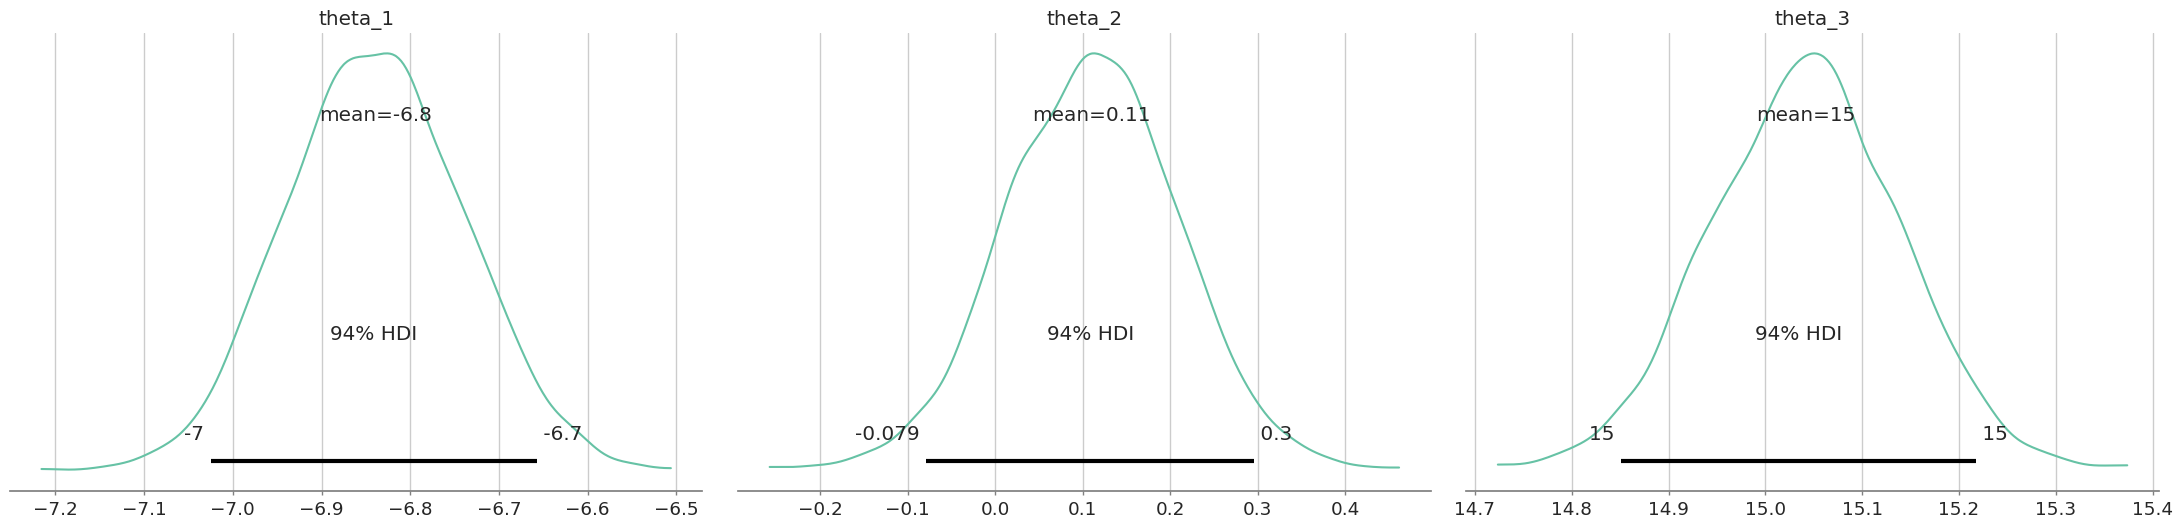

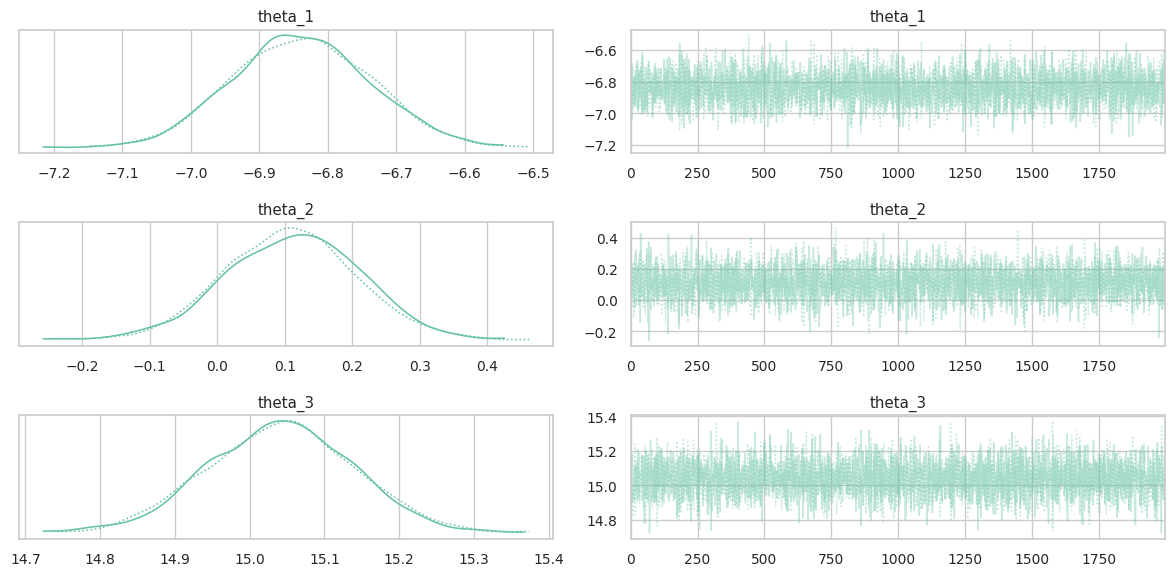

NUTS, chains_cnt=3


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta_1, theta_2, theta_3, pi]
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


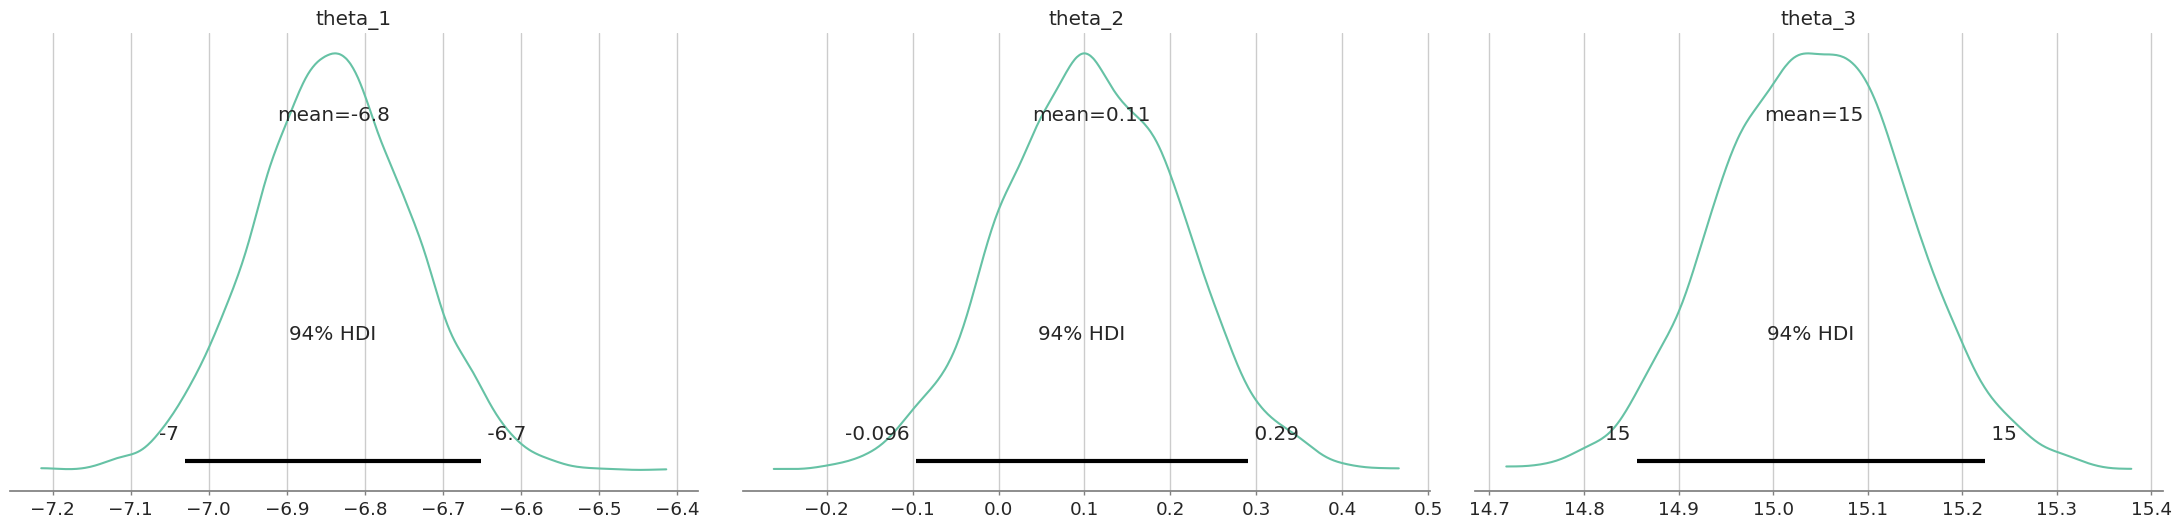

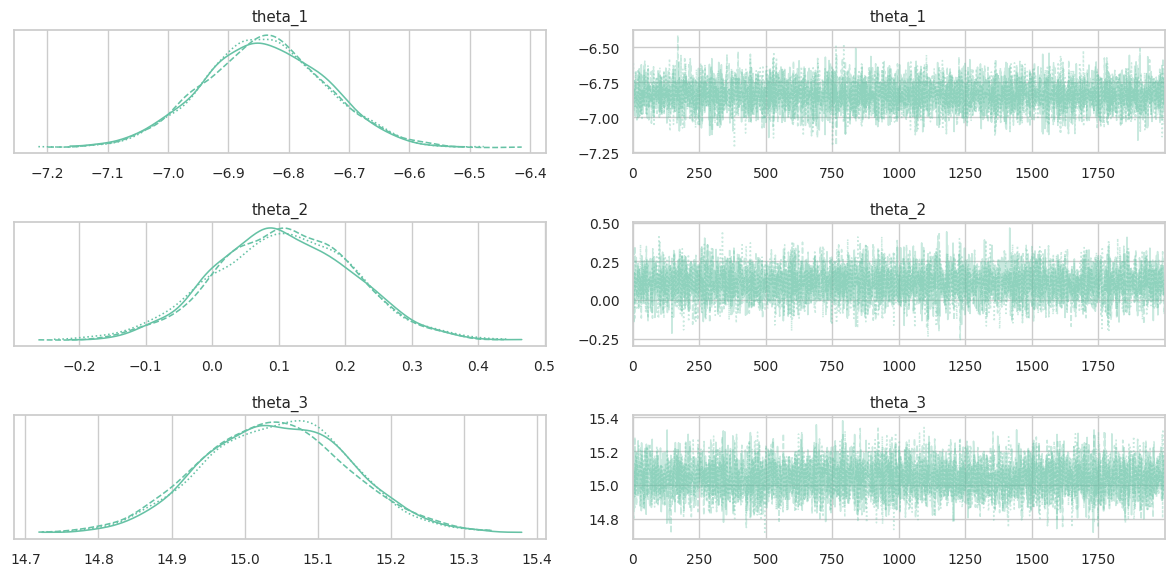

In [140]:
samplers = [pm.Metropolis, pm.HamiltonianMC, pm.NUTS]

for sampler in samplers:
    for chains_cnt in range(1, 4):
        print(f"{sampler.__name__}, chains_cnt={chains_cnt}")
        model, trace = get_model(X, sampler, chains_cnt)
        pm.plot_posterior(trace, var_names=["theta_1", "theta_2", "theta_3"])
        plt.tight_layout()
        plt.show()
        
        pm.plot_trace(trace, var_names=["theta_1", "theta_2", "theta_3"])
        plt.tight_layout()
        plt.show()


__________________
## Задача 4

**1.** Загрузите данные `flats_moscow.csv` о стоимости квартир в Москве

In [144]:
import pandas as pd

data = pd.read_csv('flats_moscow.csv', sep='\t', index_col='n')

data.head()

price  totsp  livesp  kitsp  dist  metrdist  walk  brick  floor  code
n                                                                       
1     81     58      40    6.0  12.5         7     1      1      1     3
2     75     44      28    6.0  13.5         7     1      0      1     6
3    128     70      42    6.0  14.5         3     1      1      1     3
4     95     61      37    6.0  13.5         7     1      0      1     1
5    330    104      60   11.0  10.5         7     0      1      1     3

Постройте график зависимости цены квартиры `price` от ее общей площади `totsp`. Что можно сказать о данных?

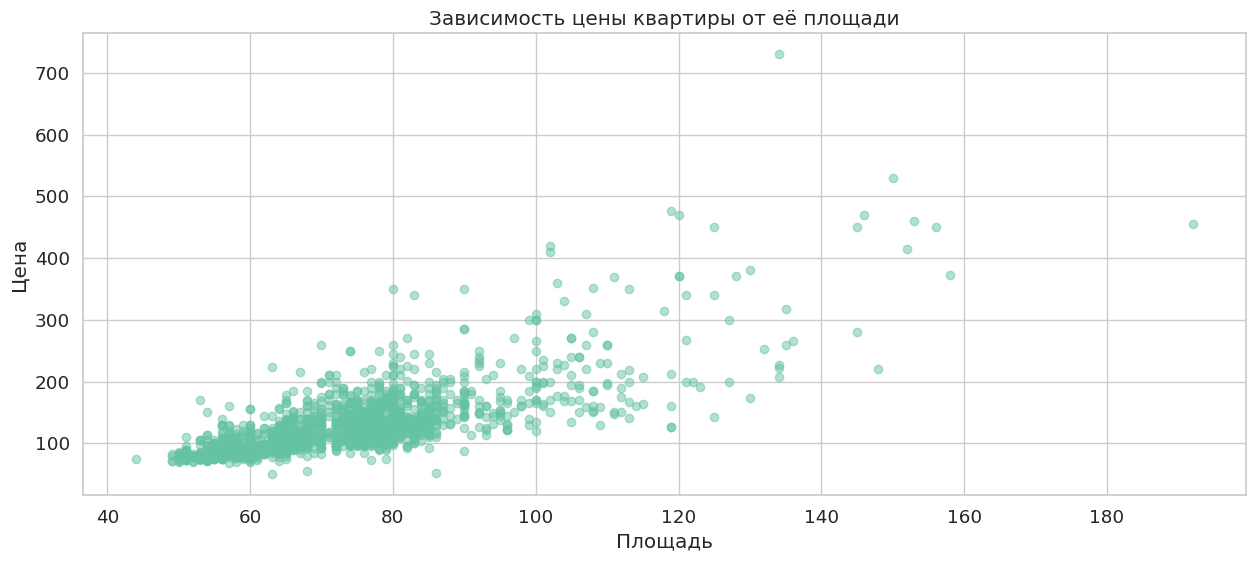

In [146]:
plt.figure(figsize=(15, 6))

plt.scatter(data['totsp'], data['price'], alpha=0.5)
plt.title('Зависимость цены квартиры от её площади')
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.grid(True)
plt.show()

Есть положительная корреляция между ценой и площадью, данные гетероскедастичны. Собственно, видимо, в предложенной ниже модели игнорируется гетерокседастичность и из-за нее будут проблемы, что можно увидеть и на анализе пораньше.

**2.** Постройте с помощью PyMC линейную регрессию для предсказания цены квартиры `price` от ее общей площади `totsp`. Используйте следующие распределения:
* Априорное распределение на коэффициенты &mdash; нормальное с нулевым средним и среднеквадратичным разбросом 20.
* Ошибка имеет нормальное распределение с нулевым средним.
* Априорное распределение на дисперсию ошибки &mdash; модуль распределения Коши.

Запишите модель формулами:

$$ price \sim N(k \cdot totsp + b, \sigma^2) $$
$$ k, b \sim N(0, 20^2) $$
$$ \sigma \sim abs(Cauchy(0, 1)) $$

Реализуйте эту модель и проведите 3000 итераций семплирования

*Замечание:* для того, чтобы связать цену и площадь и иметь возможность далее предиктивно семплировать, вам понадобится опция `dims`

In [190]:
with pm.Model() as model:
    x_data = pm.Data('x', data['totsp'].values, dims="obs")
    y_data = pm.Data('y', data['price'].values, dims="obs")
    
    k = pm.Normal('k', mu=0, sigma=20)
    b = pm.Normal('b', mu=0, sigma=20)
    sigma = pm.HalfCauchy('sigma', 1)
    
    mu = k * x_data + b
    
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_data, dims="obs")

    trace = pm.sample(3000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.


Постройте `pm.plot_trace`. Что можно по нему сказать? Какое апострериорное распределение имеют параметры модели?

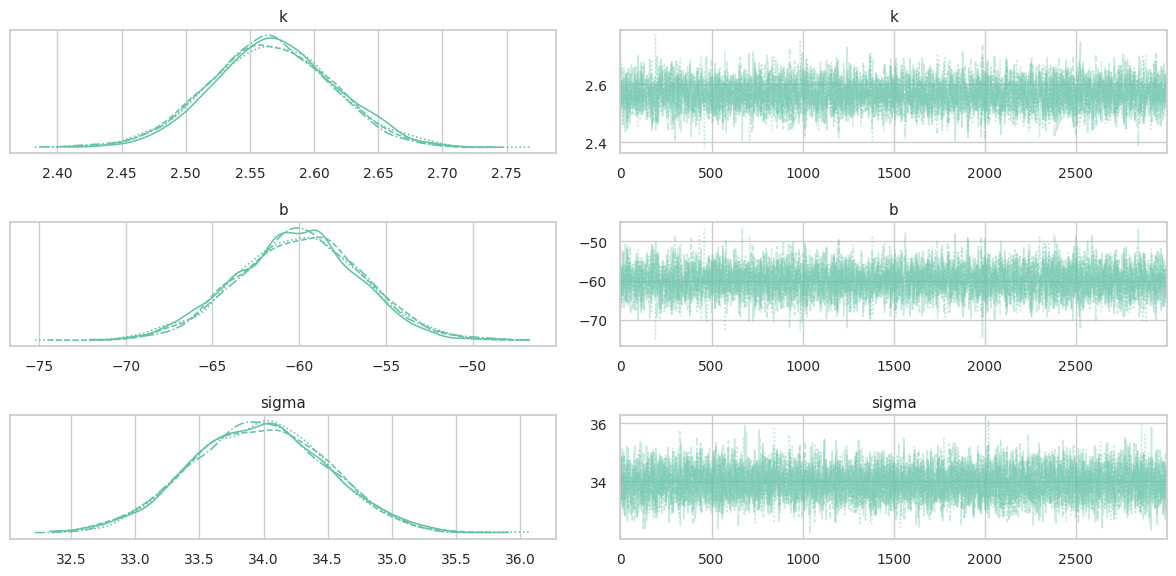

In [191]:
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

$k > 0$ и достатчоно узкий - все ок

$b$ отрицательный - что подозрительно

$\sigma \approx 30$ - может быть, слишком широкий интервал

**3.** Постройте предсказательный интервал для каждого $x$, взяв область, в которую попадает 95% вероятностной массы апостериорного распределения. Иначе говоря, на основе построенной модели нужно для каждой площади квартиры $x$ вычислить 95%-й диаппазон цен на квартиры с такой мощностью.

Для выполнения этого пункта задайте сетку значений площади квартиры и с помощью `pm.sample_posterior_predictive` проведите семплирование из предиктивного распределения.

In [192]:
x_grid = np.linspace(min(data['totsp']), max(data['totsp']), 100, dtype="int32")

with model:
    pm.set_data({"x": x_grid})
    ppc = pm.sample_posterior_predictive(trace)

y_pred = ppc.posterior_predictive['y_obs'].values

Sampling: [y_obs]


Output()

Какой размерности получится объект?

In [193]:
y_pred.shape

(4, 3000, 100)

4 цепи длинной 3000 для каждого из 100 объекта цепи

На основе полученных семплов постройте график предсказательного интервала. Для этого можно взять квантили у семплов для каждого $x$.

/tmp/ipykernel_676/843010517.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred_reshaped, hdi_prob=0.95)


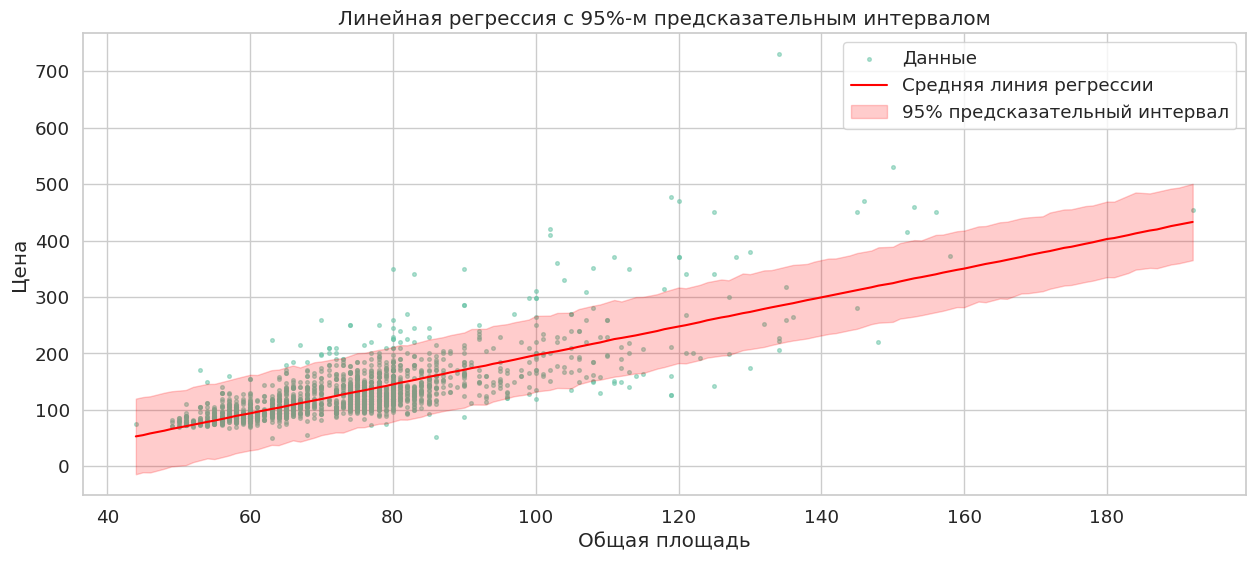

In [194]:
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])

hdi = az.hdi(y_pred_reshaped, hdi_prob=0.95)
lower_hdi = hdi[:, 0]
upper_hdi = hdi[:, 1]

y_pred_mean = y_pred_reshaped.mean(axis=0)

plt.figure(figsize=(15, 6))

plt.scatter(data['totsp'].values, data['price'].values,
            s=7, alpha=0.5, label='Данные')

plt.plot(x_grid, y_pred_mean, color='red', label='Средняя линия регрессии')
plt.fill_between(x_grid, lower_hdi, upper_hdi, color='red', alpha=0.2, label='95% предсказательный интервал')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.title('Линейная регрессия с 95%-м предсказательным интервалом')
plt.legend()
plt.grid(True)
plt.show()

Что вы можете сказать по этому графику?

Проблема при больших площадях - там точки слишком редко попадают в предсказательный интервал. Это из за гетероскедастичности. Мо в sigma зашить зависимость от площади

**4.** Предложите способ, как исправить модель. Реализуйте эту модель, постройте для нее график предсказательного интервала.

Можно зашить в $\sigma$ пропорциональность площади. Но из-за этого у меня расходится модель. Вместо этого будем предсказывать логарифм цены, он сгладит дисперсию

In [195]:
with pm.Model() as model:
    x_data = pm.Data('x', data['totsp'].values, dims="obs")
    y_data = pm.Data('y', np.log(data['price'].values), dims="obs")
    
    k = pm.Normal('k', mu=0, sigma=20)
    b = pm.Normal('b', mu=0, sigma=20)
    sigma = pm.HalfCauchy('sigma', 1)
    
    mu = k * x_data + b
    
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_data, dims="obs")

    trace = pm.sample(3000, tune=1000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.


Строим график

Sampling: [y_obs]


Output()

/tmp/ipykernel_676/374921291.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred_reshaped, hdi_prob=0.95)


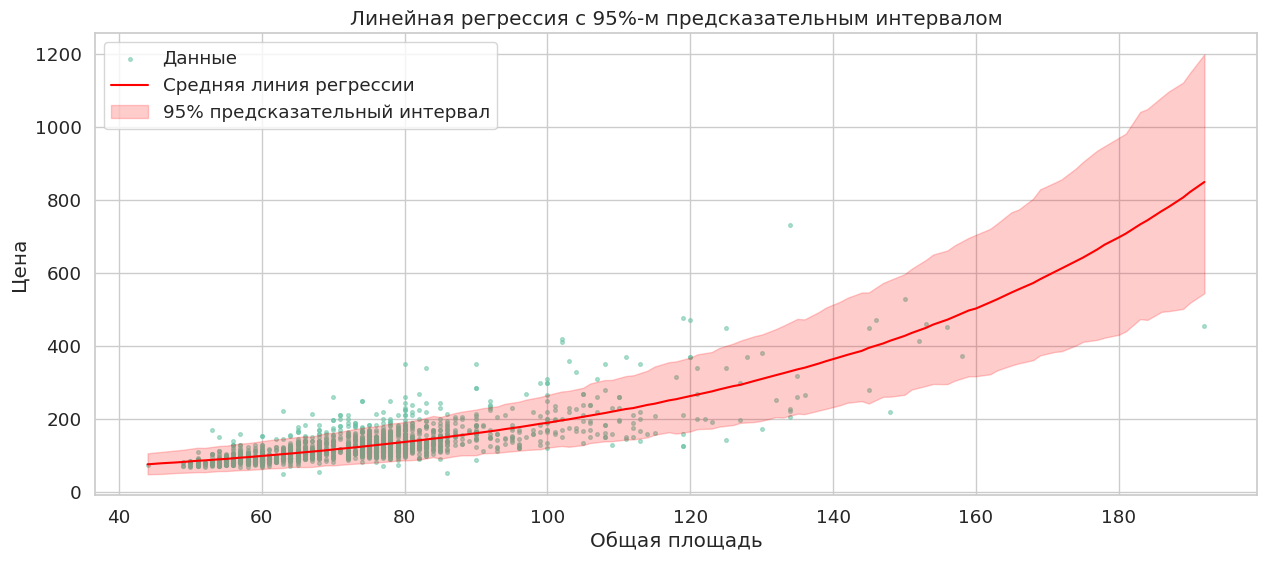

In [196]:
with model:
    pm.set_data({"x": x_grid})
    ppc = pm.sample_posterior_predictive(trace)

y_pred = ppc.posterior_predictive['y_obs'].values

y_pred_reshaped = np.exp(y_pred.reshape(-1, y_pred.shape[-1]))

hdi = az.hdi(y_pred_reshaped, hdi_prob=0.95)
lower_hdi = hdi[:, 0]
upper_hdi = hdi[:, 1]

y_pred_mean = y_pred_reshaped.mean(axis=0)

plt.figure(figsize=(15, 6))

plt.scatter(data['totsp'].values, data['price'].values,
            s=7, alpha=0.5, label='Данные')

plt.plot(x_grid, y_pred_mean, color='red', label='Средняя линия регрессии')
plt.fill_between(x_grid, lower_hdi, upper_hdi, color='red', alpha=0.2, label='95% предсказательный интервал')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.title('Линейная регрессия с 95%-м предсказательным интервалом')
plt.legend()
plt.grid(True)
plt.show()

**5.** Реализуйте ту же модель, взяв для ошибок распределение Стьюдента

In [197]:
with pm.Model() as model:
    x_data = pm.Data('x', data['totsp'].values, dims="obs")
    y_data = pm.Data('y', np.log(data['price'].values), dims="obs")
    
    k = pm.Normal('k', mu=0, sigma=20)
    b = pm.Normal('b', mu=0, sigma=20)
    sigma = pm.HalfCauchy('sigma', 1)
    
    mu = k * x_data + b
    
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=5,
                        observed=y_data, dims="obs")

    trace = pm.sample(3000, tune=1000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 24 seconds.


И тот же самый график

Sampling: [y_obs]


Output()

/tmp/ipykernel_676/374921291.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred_reshaped, hdi_prob=0.95)


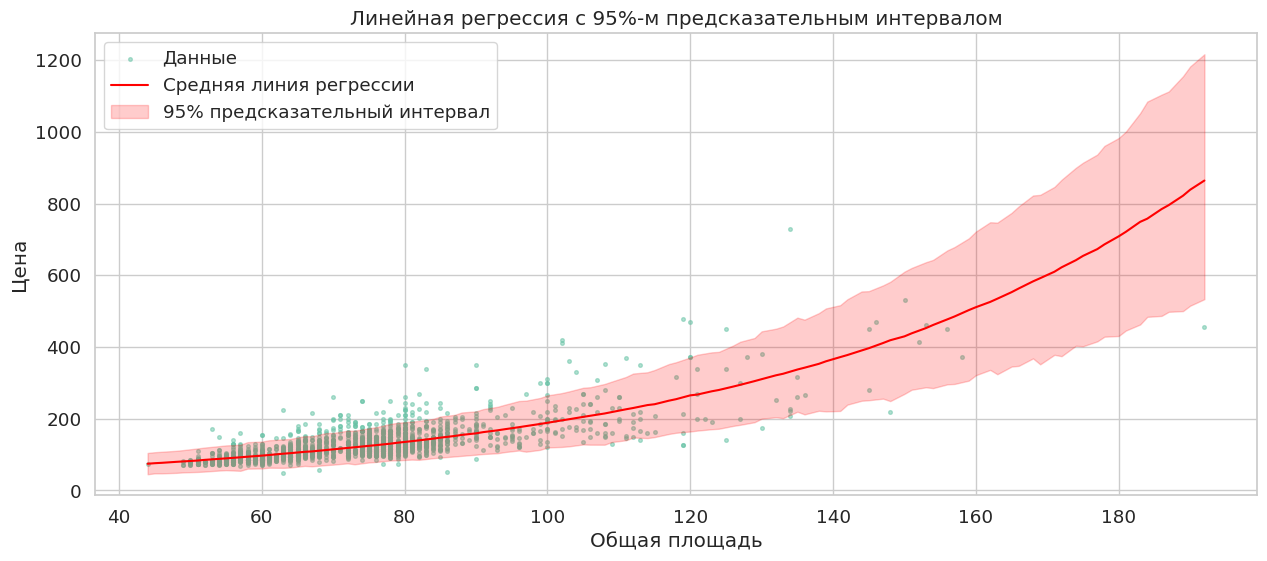

In [198]:
with model:
    pm.set_data({"x": x_grid})
    ppc = pm.sample_posterior_predictive(trace)

y_pred = ppc.posterior_predictive['y_obs'].values

y_pred_reshaped = np.exp(y_pred.reshape(-1, y_pred.shape[-1]))

hdi = az.hdi(y_pred_reshaped, hdi_prob=0.95)
lower_hdi = hdi[:, 0]
upper_hdi = hdi[:, 1]

y_pred_mean = y_pred_reshaped.mean(axis=0)

plt.figure(figsize=(15, 6))

plt.scatter(data['totsp'].values, data['price'].values,
            s=7, alpha=0.5, label='Данные')

plt.plot(x_grid, y_pred_mean, color='red', label='Средняя линия регрессии')
plt.fill_between(x_grid, lower_hdi, upper_hdi, color='red', alpha=0.2, label='95% предсказательный интервал')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.title('Линейная регрессия с 95%-м предсказательным интервалом')
plt.legend()
plt.grid(True)
plt.show()

Получилось почти то же самое

**6.** Теперь проведем небольшую аналитику. Допустим, мы хотим купить квартиру площадью 75 квадратных метров. Простройте график плотности предсказательного распределения цены такой квартиры. Посчитайте также вероятность того, что квартира площадью 75 квадратных метров имеет цену не более 100.

Sampling: [y_obs]


Output()

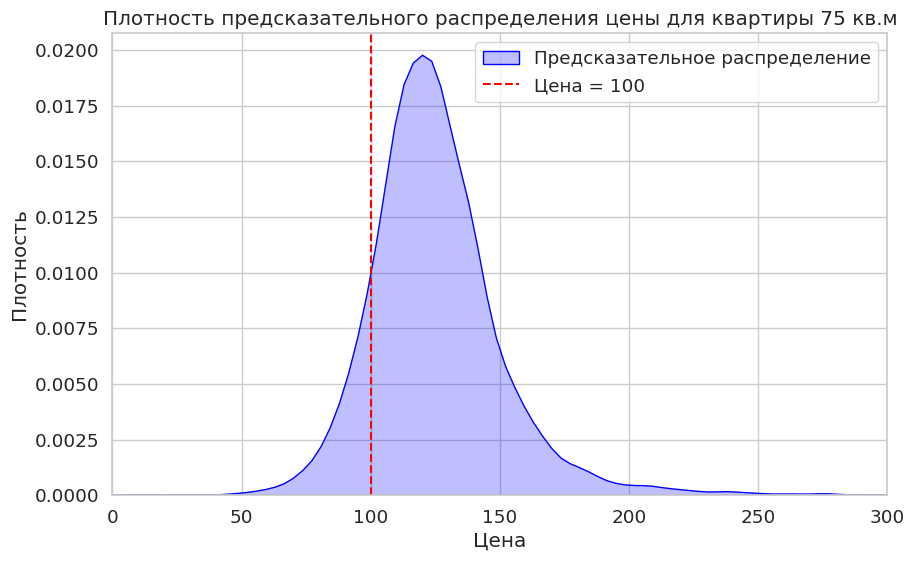

Вероятность, что цена квартиры площадью 75 не более 100: 0.1202


In [207]:
with model:
    pm.set_data({"x": [75]})
    ppc = pm.sample_posterior_predictive(trace)

y_pred = ppc.posterior_predictive['y_obs'].values.flatten()
y_pred = np.exp(y_pred)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred.flatten(), fill=True, color='blue', label='Предсказательное распределение')
plt.axvline(100, color='red', linestyle='--', label='Цена = 100')
plt.xlabel('Цена')
plt.ylabel('Плотность')
plt.title('Плотность предсказательного распределения цены для квартиры 75 кв.м')
plt.xlim(0, 300)
plt.legend()
plt.grid(True)
plt.show()

prob = np.mean(y_pred.flatten() <= 100)
print(f"Вероятность, что цена квартиры площадью 75 не более 100: {prob:.4f}")

Насколько вообще изменяется цена квартиры при увеличении ее площади на 1 метр при фиксированных остальных признаках? Постройте для этого апостериорное распределение этого параметра, а также посчитайте среднее значение и 95%-й интервал

У нас предсказание цены

$$\log price \sim N(k \cdot totsp + b, \sigma^2)$$

поэтому средняя цена квартиры меняется так:

$$\Delta \log price = \frac{\Delta price}{price} = k $$

То есть легко построить распределение *изменения относительной цены квартиры при увеличении площади на 1 метр*

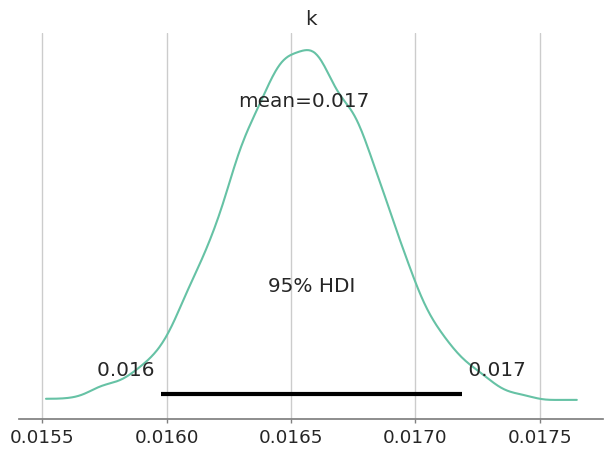

In [211]:
pm.plot_posterior(trace, var_names=['k'], hdi_prob=0.95)
plt.tight_layout()
plt.show()

In [213]:
k_samples = trace.posterior['k'].stack(sample=("chain", "draw")).values
k_hdi = az.hdi(k_samples, hdi_prob=0.95)
print(f"95%-й HDI для k: [{k_hdi[0]:.4f}, {k_hdi[1]:.4f}]")

95%-й HDI для k: [0.0160, 0.0172]


Сделайте выводы

Изменение относительной цены при увеличении площади на 1 метр $\approx$ 0.017

Можно избавиться от гетероскедастичности и логарифмированием, и изменением шума в модели. Но второй метод усложняет модель и может вызывать расходимость.

-----
## Задача 5

Пусть задана $X = (X_1, \ldots, X_n)$ &mdash; выборка из распределения $P \in \{P_t \,|\, t \in \Theta\}$. И пусть $q(t)$ &mdash; непрерывная априорная плотность $\theta$.

На занятии мы рассмотрели случаи проверки гипотез простая vs. простая и сложная (множественная) vs. сложная. Но что если мы хотим проверить гипотезу вида

$$\mathsf{H}_0\colon \theta=t_0\ \ vs.\ \ \mathsf{H}_1\colon \theta\{<, >, \neq\}t_0$$

Какая в таком случае возникает проблема?

Ответ: $Q(\theta = t_0) = \int_{\{t_0\}} q(t)dt = 0$, то есть на априоре $H_0$ вообще не встречается  - это очень плохо. Кроме того, если и апостериор будет непрерывным, то эта вероятность всегда будет равна нулю

Существует несколько способов решения данной проблемы:

**1. Модификация $\mathsf{H}_0$**

Самое простое, что мы можем сделать &mdash; расширить точечную гипотезу до множественной. Выберем интересующую нас практическую значимость $\varepsilon$. Тогда гипотеза принимает вид

$$\mathsf{H}_0\colon \theta\in \Theta_0=(t_0 - \varepsilon, t_0 + \varepsilon)\ \ vs.\ \ \mathsf{H}_1\colon \theta\notin\Theta_0$$

Это решение хорошо тем, что сводит задачу к уже рассмотренным и что связывает статистическую значимость с практической, ведь совсем маленькие отклонения нас в действительности могут не интересовать.

**2. Метод Линдли**

Этот метод сводит байесовский подход к частотному. Скажем, что будем **отвергать** $\mathsf{H}_0$ тогда и только тогда, когда $t_0 \notin (1-\alpha)$-HDR.

Данный подход также довольно прост засчет использования уже известных инструментов. Однако он нивелирует преимущество байесовского подхода, которое заключается в возможности подсчета вероятностей событий, связанных с нулевой гипотезой и параметром.

**3. Априорное распределение с атомом**

Рассмотрим априорное распределение $Q$, такое что:

* $\pi_0 = Q(\theta = t_0) > 0$
* При $t\neq t_0$ имеется плотность $\pi_1 q_1(t)$, где $\pi_1=1-\pi_0$ и $\int\limits_{\Theta_1} q_1(t) dt = 1$

Формул пугаться не стоит, на самом деле мы просто искуственно завысили вероятность в конкретной точке, сделав в ней разрыв функции распределения
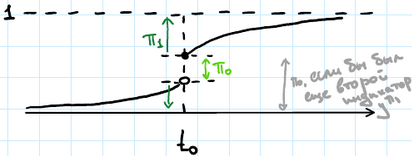

В данном способе мы во-первых сумели сохранить байесовость подхода, а во-вторых не изменили изначальный вид гипотезы. Попробуем вывести, как в данном случае будет выглядеть байесовский фактор. Вам необходимо дополнить пропуски в теоретических выкладках.

По формуле Байеса, апостериорная вероятность имеет вид $q(t|X) = \frac{1}{p(X)} \cdot q(t)p_t(X)$, где $p(X)$ &mdash; нормировочный коэффициент. Тогда отдельно по гипотезам имеем
$$q(t_0|X)=\frac{1}{p(X)} \cdot \pi_0 p_{t_0}(X)$$
$$\text{При } t\neq t_0 \text{ верно } q(t|X)=\frac{1}{p(X)} \pi_1q_1(t)p_t(X)$$

Тогда $\pi_0, \pi_1$ &mdash; априорные вероятности гипотез. Апостериорные вероятности:
$$p_0 = Q(t = t_0 | X) = \frac{Q(\theta = t_0)p_{t_0}(X)}{p(X)} = \frac{\pi_0 p_{t_0}(X)}{p(X)}$$
$$p_1 = \int\limits_{\Theta_1} q(t|X) dt = \pi_1 \frac{\int\limits_{\Theta_1}q_1(\theta)p_\theta(X) dt}{p(X)}$$

И нормировочный коэффициент:
$$p(X) = \int\limits_{\Theta} p_\theta (X) Q(dt) = \pi_0 p_{t_0}(X) + \pi_1 \int\limits_{\Theta_1} q_1(\theta) p_\theta (X) dt$$

Наконец, можем расчитать байесовский фактор в пользу $\mathsf{H}_0$ против $\mathsf{H}_1$

$$\beta = \frac{p_0 / p_1}{\pi_0 / \pi_1} = \frac{\frac{\pi_0 p_{t_0}(X)}{p(X)}}{\pi_1 \frac{\int\limits_{\Theta_1}q_1(\theta)p_\theta(X) dt}{p(X)}} \frac{\pi_1}{\pi_0}= \frac{p_{t_0}(X)}{\int\limits_{\Theta_1} q_1(\theta)p_\theta(X) dt} = \frac{L_X(t_0)}{\int\limits_{\Theta_1} q_1(\theta)L_X(t) dt}$$

---
Перейдем от теории к практике. На ЧМ по футболу в 2010 году осьминог Пауль предсказывает результаты матчей с участием сборной Германии, выбирая кормушку с флагом страны-победителя. 
	Имеется выборка $X_1, ..., X_n \sim Bern(\theta)$ &mdash; результаты предсказания матчей (правильно или неправильно). Если Пауль предсказывает наугад, то $\theta=1/2$. Предсказание ненаугад означает $\theta>1/2$. Таким образом, проверяются гипотезы $\mathsf{H}_0\colon \theta=1/2\ \ vs.\ \ \mathsf{H}_1\colon \theta>1/2$.
	
По результатам 13 испытаний Пауль верно угадывает исход матча в 11 случаях. Проверьте гипотезы следующими способами
* Частотный подход, рассмотрев критерий на основе достаточной статистики. В ответе приведите критерий, включая пороговое значение, а также значение p-value.
* Байесовский подход с модификацией гипотез, при которой в гипотезе $\mathsf{H}_0$ рассматривается принадлежность окрестности точки 1/2. В качестве априорного распределения возьмите сопряжённое. В ответе приведите апостериорные вероятности гипотез и байесовский фактор.
* Метод Линдли. В качестве априорного распределения возьмите сопряжённое. В ответе приведите множество наибольшей плотности, а также результат проверки гипотез.
* Байесовский подход. Априорная вероятность $\mathsf{H}_0$ равна $\pi_0=1/2$, в качестве априорного распределения при справедливости $\mathsf{H}_1$ рассмотрите сопряжённое. В ответе приведите апостериорные вероятности гипотез и байесовский фактор.
	
*Замечания*
* Параметры априорного распределения выберите некоторым логичным для вас способом. Поясните свой выбор. Конечно же, они не должны зависеть от результатов эксперимента.
* При расчетах полезно использовать функцию `cdf` у распределений из `scipy.stats`.
* Не забывайте про нормировку вероятностей гипотез.

In [23]:
n = 13
k = 11
alpha = 0.05

1. Частотный подход

In [34]:
result = sps.binomtest(k, n, p=0.5, alternative='greater')

result, result.proportion_ci(confidence_level=0.95)

(BinomTestResult(k=11, n=13, alternative='greater', statistic=0.8461538461538461, pvalue=0.01123046875),
 ConfidenceInterval(low=0.5899013951659118, high=1.0))

2. Окрестность точки 1/2

Сопряженное к ариорному $Beta(a, b)$ есть $Beta(a + k, b + n - k)$ ($n$ - число экспериментов, $k$ - число успехов)

За априорное будем брать $Beta(1, 1)$

In [25]:
eps = 0.1

prior_dist = sps.beta(1, 1)
apost_dist = sps.beta(1 + k, 1 + n - k)

prior0 = prior_dist.cdf(0.5 + eps) - prior_dist.cdf(0.5 - eps)
apost0 = apost_dist.cdf(0.5 + eps) - apost_dist.cdf(0.5 - eps)

prior1 = 1 - prior0
apost1 = 1 - apost0

BF = (apost0 / apost1) / (prior0 / prior1)
apost0, apost1, BF

(0.039182903705599986, 0.9608170962944, 0.16312325772185934)

3. Метод Линди

In [26]:
prior_dist = sps.beta(1, 1)
apost_dist = sps.beta(1 + k, 1 + n - k)

samples = apost_dist.rvs(100000)
hdi_95 = az.hdi(samples, hdi_prob=0.95)
hdi_95, hdi_95[0] <= 1/2 and hdi_95[1] >= 1/2

(array([0.60530925, 0.97223872]), False)

4. Байесовский подход с атомом

При $H_0: X_i \sim Bern(1/2) \Rightarrow p_{t_0}(X) = C_n^k / 2^n$



Беря в качестве $q_1$ сопряженное $Beta(1, 1)$, которое совпадает с равномерным на отрезке $[0, 1]$, получаем

$$\int\limits_{\Theta_1} q_1(\theta)p_\theta(X) dt = \int\limits_0^1 C_n^k t^k (1-t)^{n-k}dt = C_n^k B(1 + k, 1 + n - k)$$

$$p(X) = \int\limits_{\Theta} p_\theta (X) Q(dt) = \pi_0 p_{t_0}(X) + \pi_1 \int\limits_{\Theta_1} q_1(\theta) p_\theta (X) dt = \frac{C_n^k}{2} (1/2^n + B(1 + k, 1 + n - k))$$

Откуда имеем апостериорные вероятности:

$$p_0 = \frac{\pi_0 p_{t_0}(X)}{p(X)} = \frac{1}{1 + 2^n B(1 + k, 1 + n - k)} \qquad p_1 = 1 - p_0$$

И байесовский фактор

$$\beta = \frac{p_0 / p_1}{\pi_0 / \pi_1} = \frac{p_0}{1 - p_0}$$

In [30]:
import scipy.special
import pandas as pd

p0 = 1 / (1 + (2 ** n) * scipy.special.beta(k + 1, n - k + 1))
p1 = 1 - p0

bf = p0 / p1

p0, p1, bf

(0.11762171477811288, 0.8823782852218871, 0.13330078125)

Итого

1. Частотный подход:

Критерий: биномиальное распределение с порогом 0.58, статистика 0.84, p-value = 0.011.

Результат: отвергаем нулевую гипотезу.

2. Байесовский подход (окрестности):

Апостериорные вероятности: P(H0)=0.039, P(H1)=0.960

Байесовский фактор: 0.163 (данные против H0)

3. Метод Линдли:

95% HDI [0.605, 0.97].

Включает 1/2: Нет. Отвергаем нулевую гипотезу.

4. Байесовский подход (атом):

Апостериорные вероятности: P(H0)=0.117, P(H1)=0.882.

Байесовский фактор: 0.133 (данные против H0)

Если углубиться в историю осьминога, окажется, что он почти всегда выбирал в качестве фаворита страны с желтым флагом, в данном случае Германию. Предсказания статистически отличаются от случайных, что мы тут показали 4 способами - цвет флага ему таким образом подсказывал результат

Можно провести такую же статистическую проверку того, **выбирает ли он страну с желтым флагом случайно или нет.** Все формулы будут абсолютно такими же

Имеется выборка $X_1, ..., X_n \sim Bern(\theta)$ &mdash; цвета флага выбранной Паулем страны (1 если желтый, 0 - иначе)
Если Пауль выбирает страну случайно, то $\theta=1/2$. Выбор страны с желтым флагом означает $\theta>1/2$. Таким образом, проверяются гипотезы $\mathsf{H}_0\colon \theta=1/2\ \ vs.\ \ \mathsf{H}_1\colon \theta>1/2$.

Перейдем на википедию https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D1%83%D0%BB%D1%8C_(%D0%BE%D1%81%D1%8C%D0%BC%D0%B8%D0%BD%D0%BE%D0%B3)

Есть 11 матчей, где ровно одна страна была с жёлтым флагом, в 10 случаях он выбрал страну с жёлтым флагом (ровно один раз он выбрал Сербию против Германии - и, что удивительно, угадал) (ясно, что нас не интересуют те случаи, когда оба флага имели желтый цвет или ни одна из стран не была с желтым флагом)

In [42]:
n = 11
k = 10

1. Частотный подход

In [43]:
result = sps.binomtest(k, n, p=0.5, alternative='greater')

result, result.proportion_ci(confidence_level=0.95)

(BinomTestResult(k=10, n=11, alternative='greater', statistic=0.9090909090909091, pvalue=0.005859375),
 ConfidenceInterval(low=0.6356405107527333, high=1.0))

2. Окрестность точки 1/2

In [44]:
eps = 0.1

prior_dist = sps.beta(1, 1)
apost_dist = sps.beta(1 + k, 1 + n - k)

prior0 = prior_dist.cdf(0.5 + eps) - prior_dist.cdf(0.5 - eps)
apost0 = apost_dist.cdf(0.5 + eps) - apost_dist.cdf(0.5 - eps)

prior1 = 1 - prior0
apost1 = 1 - apost0

BF = (apost0 / apost1) / (prior0 / prior1)
apost0, apost1, BF

(0.019272273919999992, 0.98072772608, 0.07860397297844077)

3. Метод Линди

In [45]:
prior_dist = sps.beta(1, 1)
apost_dist = sps.beta(1 + k, 1 + n - k)

samples = apost_dist.rvs(100000)
hdi_95 = az.hdi(samples, hdi_prob=0.95)
hdi_95, hdi_95[0] <= 1/2 and hdi_95[1] >= 1/2

(array([0.65953685, 0.99369227]), False)

4. Байесовский подход с атомом

In [46]:
import scipy.special
import pandas as pd

p0 = 1 / (1 + (2 ** n) * scipy.special.beta(k + 1, n - k + 1))
p1 = 1 - p0

bf = p0 / p1

p0, p1, bf

(0.06055045871559633, 0.9394495412844037, 0.06445312499999999)

Итого:

1. Частотный подход:

Критерий: биномиальное распределение с порогом 0.58, статистика 0.91, p-value = 0.0059.

Результат: отвергаем нулевую гипотезу.

2. Байесовский подход (окрестности):

Апостериорные вероятности: P(H₀) = 0.019, P(H₁) = 0.981

Байесовский фактор: 0.079

3. Метод Линдли:

95% HDI: [0.660, 0.994]

Включает 1/2: Нет. Отвергаем нулевую гипотезу.

4. Байесовский подход (атом):

Апостериорные вероятности: P(H₀) = 0.061, P(H₁) = 0.939

Байесовский фактор: 0.064

То есть абсолютно такими же методами мы можем сделать вывод, что Пауль неслучайно выбирает страну с жёлтым флагом